# Aligning HST Mosaics 

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

# Introduction

This notebook demonstrates how to align and drizzle mosaicked tiles of the Eagle Nebula (M16) obtained with WFC3 with both UVIS and IR detectors. It is based on the example highlighted in the following WFC3 technical report: [ISR 2015-09: Combining WFC3 Mosaics of M16 with DrizzlePac](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-09.pdf)
and highlights special features in DrizzlePac to improve mosaics. 

In prior alignment [tutorials](https://archive.stsci.edu/prepds/heritage/horsehead/readme_HLSP_v3.txt), building up an aligned set of tiles required an iterative approach. Now, mosaic alignment can be achieved in a single step by building up an expanded reference catalog ‘on-the-fly’. New sky matching options make it easier to produce seamless mosaics, which can be challenging for extended sources with little or no blank sky. 

In [1]:
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from astropy.table import Table
from astropy.io import fits
from astropy.io import ascii
from astropy.visualization import ZScaleInterval
from IPython.display import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


# 1. Observations

Mosaics of the Eagle Nebula were acquired by HST GO/DD [program 13926](http://www.stsci.edu/cgi-bin/get-proposal-info?id=13926&observatory=HST) in September 2014 for HST's 25th Annivery. A 2x2 tile mosaic with the IR detector (~4 arcmin across) was observed in the F110W and F160W filters. 

A slightly larger 2x2 mosaic with the UVIS detector (~5 arcmin across) was observed with the F502N, F657N, and F673N filters. Small dithers between exposures in a given tile will fill in the UVIS chip gap and allow for the rejection of cosmic rays and detector artifacts. More detail on the observing strategy may be found in the [Phase II file](http://www.stsci.edu/hst/phase2-public/13926.pro).

Two additional UVIS tiles overlap the central portion of 2x2 mosaic in order to have very high signal-to-noise in the Eagle's pillars. These two visits (09,10) were not included in this example for brevity. The data used in this notebook example is also limited to the IR/F160W filter (visits 01-04) and UVIS/F657N filters (visits 05-08), shown in the diagrams below.
>      IR Mosaic           UVIS Mosaic         UVIS(overlap)
>      ____ ____            ____ ____            ____ 
>     |    |    |          |    |    |          |    |   
>     | 02 | 01 |          | 06 | 05 |          | 09 | 
>     |____|____|          |____|____|          |____|
>     |    |    |          |    |    |          |    |  
>     | 04 | 03 |          | 08 | 07 |          | 10 |
>     |____|____|          |____|____|          |____|

# 2. MAST Download

In the steps below, the calibrated IR data (\*\_flt.fits) and the calibrated, CTE-corrected UVIS data (\*\_flc.fits) are retrieved from MAST and placed in the same directory as this notebook, along with the associated telemetry and engineering files (\*\_spt.fits).

In [2]:
# Retrieve the IR/F160W calibrated FLT and SPT data products  
science_list = Observations.query_criteria(proposal_id='13926', filters='F160W')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',
                               productSubGroupDescription=['FLT', 'SPT'])

science_files = glob.glob(os.path.join(os.curdir, 'science', 'mastDownload', 'HST', '*', '*fits'))
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './' + root)
shutil.rmtree('science/')

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


In [3]:
# Obtain the UVIS/F657N calibrated FLC and SPT data products from visits 05-08 
science_list = Observations.query_criteria(proposal_id='13926', filters='F657N', obs_id='ICK90[5678]*')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',
                               productSubGroupDescription=['FLC', 'SPT'])

science_files = glob.glob(os.path.join(os.curdir, 'science', 'mastDownload', 'HST', '*', '*fits'))
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './' + root)
shutil.rmtree('science/')

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


# 3. Dithers

## 3a. IR detector
IR exposures were obtained in Visits 01-04. (The visit ID is found in the 5th and 6th character of the filename). Each visit (mosaic tile) consists of a pair of exposures using the WFC3-IR-DITHER-BLOB dither of 7.2" along the y-axis (pattern_orient=90 degrees). This dither can be seen when comparing the POSTARG2 keyword between pairs of exposures in a given visit in the table below. 

Pairs of IR exposures making up each visit are referred to as v01a and v01b in this notebook. The first four images listed in the table below are associated with v01a and the last four with v01b. 

In [4]:
collect_ir = ImageFileCollection('./', glob_include="*flt.fits", ext=0,
                                 keywords=["asn_id", "detector", "filter", "nsamp",
                                           "exptime", "postarg1", "postarg2"])

ir_table = collect_ir.summary
ir_table['exptime'].format = '7.1f'
ir_table['postarg1'].format = '7.2f'
ir_table['postarg2'].format = '7.2f'
ir_table

<Table masked=True length=8>
       file          asn_id  detector filter nsamp exptime postarg1 postarg2
      str18           str9     str2    str5  int64 float64 float64  float64 
------------------ --------- -------- ------ ----- ------- -------- --------
ick901hzq_flt.fits ICK901030       IR  F160W    16   702.9   -62.57   -62.05
ick901i7q_flt.fits ICK901030       IR  F160W    16   702.9   -62.57   -54.85
ick902n9q_flt.fits ICK902030       IR  F160W    16   702.9    62.57   -62.05
ick902neq_flt.fits ICK902030       IR  F160W    16   702.9    62.57   -54.85
ick903n4q_flt.fits ICK903030       IR  F160W    16   702.9   -62.57    54.85
ick903ncq_flt.fits ICK903030       IR  F160W    16   702.9   -62.57    62.05
ick904obq_flt.fits ICK904030       IR  F160W    16   702.9    62.57    54.85
ick904ogq_flt.fits ICK904030       IR  F160W    16   702.9    62.57    62.05

## 3b. UVIS detector

UVIS exposures were acquired in Visits 05-08. Each UVIS visit (tile) consists of a set of 3 dithered exposures using the WFC3-UVIS-MOSAIC-LINE pattern, with an offset ~12" along a 65 degree diagonal. This dither can be seen in the POSTARG1, POSTARG2 offsets which are ~5" in X and ~10" in Y between exposures in a given visit. 

Sets of three exposures making up each UVIS visit are referred to as v05a, v05b, v05c in this notebook.

In [5]:
collect_uvis = ImageFileCollection('./', glob_include="*flc.fits", ext=0,
                                   keywords=["asn_id", "detector", "filter", "exptime", "postarg1", "postarg2"])
    
uvis_table = collect_uvis.summary
uvis_table['exptime'].format = '7.1f'
uvis_table['postarg1'].format = '7.2f'
uvis_table['postarg2'].format = '7.2f'
uvis_table

<Table masked=True length=12>
       file          asn_id  detector filter exptime postarg1 postarg2
      str18           str9     str4    str5  float64 float64  float64 
------------------ --------- -------- ------ ------- -------- --------
ick905k5q_flc.fits ICK905040     UVIS  F657N   600.0   -65.38   -74.27
ick905keq_flc.fits ICK905040     UVIS  F657N   600.0   -60.31   -63.40
ick905knq_flc.fits ICK905040     UVIS  F657N   600.0   -55.24   -52.52
ick906kwq_flc.fits ICK906040     UVIS  F657N   600.0    65.38   -65.13
ick906l5q_flc.fits ICK906040     UVIS  F657N   600.0    70.46   -54.25
ick906leq_flc.fits ICK906040     UVIS  F657N   600.0    75.53   -43.38
ick907nkq_flc.fits ICK907040     UVIS  F657N   600.0   -65.38    65.13
ick907o1q_flc.fits ICK907040     UVIS  F657N   600.0   -60.31    76.00
ick907ouq_flc.fits ICK907040     UVIS  F657N   600.0   -55.24    86.88
ick908pbq_flc.fits ICK908040     UVIS  F657N   600.0    65.38    74.27
ick908pkq_flc.fits ICK908040     UVIS  F657N   600.0    70.46    85.15
ick908ptq_flc.fits ICK908040     UVIS  F657N   600.0    75.53    96.02

# 4. TweakReg for Mosaics

Before combining observations with AstroDrizzle, the WCS keywords in the header of each input frame
should be aligned to sub-pixel accuracy. This may be achieved with TweakReg, which allows users to align sets of images to one another or to an external astrometric reference frame. TweakReg has been enhanced to support the alignment of observations that cover a large area on the sky. Making use of the `expand_refcat` parameter, TweakReg will build up an expanded reference catalog on the sky to be used for alignment. When set to 'True', TweakReg selects two images from the input list with the largest overlap on the sky, generates source catalogs for each image, and computes a fit (shift, rotation, and/or scale change) from the matched source list. 

Next, the algorithm computes the area of overlap of each of these two images with the rest of the input images, and the one with the largest total overlap on the sky is selected as the reference image. Sources from the second image that have not been matched to the reference image catalog are considered good new sources and are added to the reference catalog. In this way, the reference catalog keeps expanding with each new matched image. With a large (expanded) reference catalog it is therefore possible to align images that had no direct overlap with the starting image.

## 4a. IR Alignment

For this large multi-filter dataset, the user should carefully consider which observations to align and combine first. These will serve as a reference image for aligning additional filters. The broadband IR images of M16 contain a large number of stars distributed uniformly over the field of view. The UVIS frames, on the other hand, are largely devoid of point sources and full of cosmic-rays which can trip up TweakReg when trying to compute a fit. Even though the IR detector has a smaller footprint on the sky and the IR PSF is more undersampled, the high density of stars makes it a better anchor for aligning the UVIS tiles.

Of the two IR filters, F160W has the largest number of point sources and therefore makes a good choice for the reference image. To generate source lists for matching, the TweakReg parameter `conv_width` should be set to approximately twice the FWHM of the PSF, ~2.5 pixels for IR observations and ~3.5 pixels for UVIS observations. TweakReg will automatically compute the standard deviation of the sky background (`skysigma`), so the number of sources in each catalog may be controlled simply by changing the ‘threshold’ parameter. 

In this example, TweakReg is run in ‘non-interactive’ mode (`interactive='False'`) so that the astrometric fit residuals and vectors diagrams will be saved as png files in the user’s local directory for inspection. Once the parameters have been fine-tuned and the fit looks adequate, users may run TweakReg a second time (see below) to update the image header WCS keywords by setting the parameter `updatehdr` to True.

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 20:09:53.233 (20/03/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 20:09:53.233 (20/03/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 7.3.0]


Python Version [GCC 7.3.0]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	False


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	input :	*flt.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ick901hzq_flt.fits


    ick901hzq_flt.fits


INFO:drizzlepac.tweakreg:    ick901i7q_flt.fits


    ick901i7q_flt.fits


INFO:drizzlepac.tweakreg:    ick902n9q_flt.fits


    ick902n9q_flt.fits


INFO:drizzlepac.tweakreg:    ick902neq_flt.fits


    ick902neq_flt.fits


INFO:drizzlepac.tweakreg:    ick903n4q_flt.fits


    ick903n4q_flt.fits


INFO:drizzlepac.tweakreg:    ick903ncq_flt.fits


    ick903ncq_flt.fits


INFO:drizzlepac.tweakreg:    ick904obq_flt.fits


    ick904obq_flt.fits


INFO:drizzlepac.tweakreg:    ick904ogq_flt.fits


    ick904ogq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	2.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	False


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*flt.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	50


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:===  Source finding for image 'ick901hzq_flt.fits':


===  Source finding for image 'ick901hzq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick901hzq_flt.fits', EXT=('SCI', 1) started at: 20:09:53.328 (20/03/2019)


  #  Source finding for 'ick901hzq_flt.fits', EXT=('SCI', 1) started at: 20:09:53.328 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.026968


INFO:drizzlepac.catalogs:###Source finding finished at: 20:09:53.45 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 547 objects.


     Found 547 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick901hzq_flt.fits': 547


===  FINAL number of objects in image 'ick901hzq_flt.fits': 547


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick901i7q_flt.fits':


===  Source finding for image 'ick901i7q_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick901i7q_flt.fits', EXT=('SCI', 1) started at: 20:09:53.638 (20/03/2019)


  #  Source finding for 'ick901i7q_flt.fits', EXT=('SCI', 1) started at: 20:09:53.638 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.065160


INFO:drizzlepac.catalogs:###Source finding finished at: 20:09:53.707 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 522 objects.


     Found 522 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick901i7q_flt.fits': 522


===  FINAL number of objects in image 'ick901i7q_flt.fits': 522


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick902n9q_flt.fits':


===  Source finding for image 'ick902n9q_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick902n9q_flt.fits', EXT=('SCI', 1) started at: 20:09:53.838 (20/03/2019)


  #  Source finding for 'ick902n9q_flt.fits', EXT=('SCI', 1) started at: 20:09:53.838 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.444899


INFO:drizzlepac.catalogs:###Source finding finished at: 20:09:54.012 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 574 objects.


     Found 574 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick902n9q_flt.fits': 574


===  FINAL number of objects in image 'ick902n9q_flt.fits': 574


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick902neq_flt.fits':


===  Source finding for image 'ick902neq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick902neq_flt.fits', EXT=('SCI', 1) started at: 20:09:54.179 (20/03/2019)


  #  Source finding for 'ick902neq_flt.fits', EXT=('SCI', 1) started at: 20:09:54.179 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.449846


INFO:drizzlepac.catalogs:###Source finding finished at: 20:09:54.323 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 601 objects.


     Found 601 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick902neq_flt.fits': 601


===  FINAL number of objects in image 'ick902neq_flt.fits': 601


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick903n4q_flt.fits':


===  Source finding for image 'ick903n4q_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick903n4q_flt.fits', EXT=('SCI', 1) started at: 20:09:54.451 (20/03/2019)


  #  Source finding for 'ick903n4q_flt.fits', EXT=('SCI', 1) started at: 20:09:54.451 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.487839


INFO:drizzlepac.catalogs:###Source finding finished at: 20:09:54.523 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 481 objects.


     Found 481 objects.

INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick903n4q_flt.fits': 481


===  FINAL number of objects in image 'ick903n4q_flt.fits': 481


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick903ncq_flt.fits':


===  Source finding for image 'ick903ncq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick903ncq_flt.fits', EXT=('SCI', 1) started at: 20:09:54.659 (20/03/2019)


  #  Source finding for 'ick903ncq_flt.fits', EXT=('SCI', 1) started at: 20:09:54.659 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.466888


INFO:drizzlepac.catalogs:###Source finding finished at: 20:09:54.834 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 496 objects.


     Found 496 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick903ncq_flt.fits': 496


===  FINAL number of objects in image 'ick903ncq_flt.fits': 496


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick904obq_flt.fits':


===  Source finding for image 'ick904obq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick904obq_flt.fits', EXT=('SCI', 1) started at: 20:09:54.964 (20/03/2019)


  #  Source finding for 'ick904obq_flt.fits', EXT=('SCI', 1) started at: 20:09:54.964 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.433189


INFO:drizzlepac.catalogs:###Source finding finished at: 20:09:55.064 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 478 objects.


     Found 478 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick904obq_flt.fits': 478


===  FINAL number of objects in image 'ick904obq_flt.fits': 478


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick904ogq_flt.fits':


===  Source finding for image 'ick904ogq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick904ogq_flt.fits', EXT=('SCI', 1) started at: 20:09:55.238 (20/03/2019)


  #  Source finding for 'ick904ogq_flt.fits', EXT=('SCI', 1) started at: 20:09:55.238 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 3.438146


INFO:drizzlepac.catalogs:###Source finding finished at: 20:09:55.333 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 445 objects.


     Found 445 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick904ogq_flt.fits': 445


===  FINAL number of objects in image 'ick904ogq_flt.fits': 445


INFO:drizzlepac.imgclasses:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "ick902neq_flt.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'ick902neq_flt.fits'


derived from 'ick902neq_flt.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	2.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	0.3


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	shift160_flt.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick902n9q_flt.fits


Performing fit for: ick902n9q_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick902n9q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick902n9q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.5736290149171719 -0.552716467388656


Found initial X and Y shifts of  -0.5736290149171719 -0.552716467388656


INFO:drizzlepac.tweakutils:    with significance of  3588.809691248618 and  494.0  matches


    with significance of  3588.809691248618 and  494.0  matches


INFO:drizzlepac.imgclasses:Found 501 matches for ick902n9q_flt.fits...


Found 501 matches for ick902n9q_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick902n9q_flt.fits : 


Computed  rscale  fit for  ick902n9q_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0278  YSH: 0.0868    ROT: 359.9997493    SCALE: 0.999998


XSH: 0.0278  YSH: 0.0868    ROT: 359.9997493    SCALE: 0.999998


INFO:drizzlepac.imgclasses:XRMS: 0.062    YRMS: 0.045


XRMS: 0.062    YRMS: 0.045


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.8e-06 (deg)   RMS_DEC: 3.7e-08 (deg)


RMS_RA: 2.8e-06 (deg)   RMS_DEC: 3.7e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  483  objects.


Final solution based on  483  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick902n9q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick902n9q_flt_catalog_fit.match


wrote XY data to:  ick902n9q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  483


Total # points:  483


INFO:drizzlepac.tweakutils:# of points after clipping:  483


# of points after clipping:  483


INFO:drizzlepac.tweakutils:Total # points:  483


Total # points:  483


INFO:drizzlepac.tweakutils:# of points after clipping:  483


# of points after clipping:  483


INFO:drizzlepac.imgclasses:Adding 73 new sources to the reference catalog for a total of 674 sources.


Adding 73 new sources to the reference catalog for a total of 674 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick902n9q_flt.fits...


....Updating header for ick902n9q_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick902n9q_flt.fits['SCI',1]


Processing ick902n9q_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick902n9q_flt.fits[1]


Updating header for ick902n9q_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.074671266089569e-05 -1.9448980187533828e-05


CD_11  CD_12: -3.074671266089569e-05 -1.9448980187533828e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1672030923177808e-05 2.73976711700133e-05


CD_21  CD_22: -2.1672030923177808e-05 2.73976711700133e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.72154551288037 -13.811945663954916


CRVAL    : 274.72154551288037 -13.811945663954916


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13542084317230305


Plate Scale : 0.13542084317230305


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.37007108954064


ORIENTAT : -35.37007108954064


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick904obq_flt.fits


Performing fit for: ick904obq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick904obq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick904obq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -9.519914696774048 -12.59454156244569


Found initial X and Y shifts of  -9.519914696774048 -12.59454156244569


INFO:drizzlepac.tweakutils:    with significance of  935.6040829325191 and  62.0  matches


    with significance of  935.6040829325191 and  62.0  matches


INFO:drizzlepac.imgclasses:Found 67 matches for ick904obq_flt.fits...


Found 67 matches for ick904obq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick904obq_flt.fits : 


Computed  rscale  fit for  ick904obq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -8.7467  YSH: -12.1249    ROT: 359.9972173    SCALE: 0.999916


XSH: -8.7467  YSH: -12.1249    ROT: 359.9972173    SCALE: 0.999916


INFO:drizzlepac.imgclasses:XRMS: 0.049    YRMS: 0.043


XRMS: 0.049    YRMS: 0.043


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.4e-06 (deg)   RMS_DEC: 2.6e-07 (deg)


RMS_RA: 2.4e-06 (deg)   RMS_DEC: 2.6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  63  objects.


Final solution based on  63  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick904obq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick904obq_flt_catalog_fit.match


wrote XY data to:  ick904obq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  63


Total # points:  63


INFO:drizzlepac.tweakutils:# of points after clipping:  63


# of points after clipping:  63


INFO:drizzlepac.tweakutils:Total # points:  63


Total # points:  63


INFO:drizzlepac.tweakutils:# of points after clipping:  63


# of points after clipping:  63


INFO:drizzlepac.imgclasses:Adding 411 new sources to the reference catalog for a total of 1087 sources.


Adding 411 new sources to the reference catalog for a total of 1087 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick904obq_flt.fits...


....Updating header for ick904obq_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick904obq_flt.fits['SCI',1]


Processing ick904obq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick904obq_flt.fits[1]


Updating header for ick904obq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.0746462243591494e-05 -1.9453855801173395e-05


CD_11  CD_12: -3.0746462243591494e-05 -1.9453855801173395e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.16774903378565e-05 2.7397431095985995e-05


CD_21  CD_22: -2.16774903378565e-05 2.7397431095985995e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7403672823452 -13.838256729347277


CRVAL    : 274.7403672823452 -13.838256729347277


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.1354204049729195


Plate Scale : 0.1354204049729195


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.377087243381496


ORIENTAT : -35.377087243381496


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick904ogq_flt.fits


Performing fit for: ick904ogq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick904ogq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick904ogq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -9.59207242664322 -12.59454156244569


Found initial X and Y shifts of  -9.59207242664322 -12.59454156244569


INFO:drizzlepac.tweakutils:    with significance of  8875.919670659487 and  400.0  matches


    with significance of  8875.919670659487 and  400.0  matches


INFO:drizzlepac.imgclasses:Found 403 matches for ick904ogq_flt.fits...


Found 403 matches for ick904ogq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick904ogq_flt.fits : 


Computed  rscale  fit for  ick904ogq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -8.7904  YSH: -12.2218    ROT: 359.9978216    SCALE: 1.000069


XSH: -8.7904  YSH: -12.2218    ROT: 359.9978216    SCALE: 1.000069


INFO:drizzlepac.imgclasses:XRMS: 0.063    YRMS: 0.044


XRMS: 0.063    YRMS: 0.044


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.8e-06 (deg)   RMS_DEC: 5.9e-09 (deg)


RMS_RA: 2.8e-06 (deg)   RMS_DEC: 5.9e-09 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  388  objects.


Final solution based on  388  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick904ogq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick904ogq_flt_catalog_fit.match


wrote XY data to:  ick904ogq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  388


Total # points:  388


INFO:drizzlepac.tweakutils:# of points after clipping:  388


# of points after clipping:  388


INFO:drizzlepac.tweakutils:Total # points:  388


Total # points:  388


INFO:drizzlepac.tweakutils:# of points after clipping:  388


# of points after clipping:  388


INFO:drizzlepac.imgclasses:Adding 42 new sources to the reference catalog for a total of 1129 sources.


Adding 42 new sources to the reference catalog for a total of 1129 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick904ogq_flt.fits...


....Updating header for ick904ogq_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick904ogq_flt.fits['SCI',1]


Processing ick904ogq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick904ogq_flt.fits[1]


Updating header for ick904ogq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.074111073989084e-05 -1.945023235068844e-05


CD_11  CD_12: -3.074111073989084e-05 -1.945023235068844e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1673451459347432e-05 2.7392663350102456e-05


CD_21  CD_22: -2.1673451459347432e-05 2.7392663350102456e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.74155168546395 -13.839886019708272


CRVAL    : 274.74155168546395 -13.839886019708272


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13541699262772708


Plate Scale : 0.13541699262772708


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.37675620970376


ORIENTAT : -35.37675620970376


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick901hzq_flt.fits


Performing fit for: ick901hzq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick901hzq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick901hzq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.6796479454244135 0.27779886308622537


Found initial X and Y shifts of  -0.6796479454244135 0.27779886308622537


INFO:drizzlepac.tweakutils:    with significance of  554.6910336909574 and  40.0  matches


    with significance of  554.6910336909574 and  40.0  matches


INFO:drizzlepac.imgclasses:Found 46 matches for ick901hzq_flt.fits...


Found 46 matches for ick901hzq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick901hzq_flt.fits : 


Computed  rscale  fit for  ick901hzq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.1573  YSH: 0.4217    ROT: 359.9988935    SCALE: 1.000075


XSH: -0.1573  YSH: 0.4217    ROT: 359.9988935    SCALE: 1.000075


INFO:drizzlepac.imgclasses:XRMS: 0.058    YRMS: 0.041


XRMS: 0.058    YRMS: 0.041


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.6e-06 (deg)   RMS_DEC: 2.6e-08 (deg)


RMS_RA: 2.6e-06 (deg)   RMS_DEC: 2.6e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  44  objects.


Final solution based on  44  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick901hzq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick901hzq_flt_catalog_fit.match


wrote XY data to:  ick901hzq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  44


Total # points:  44


INFO:drizzlepac.tweakutils:# of points after clipping:  44


# of points after clipping:  44


INFO:drizzlepac.tweakutils:Total # points:  44


Total # points:  44


INFO:drizzlepac.tweakutils:# of points after clipping:  44


# of points after clipping:  44


INFO:drizzlepac.imgclasses:Adding 501 new sources to the reference catalog for a total of 1630 sources.


Adding 501 new sources to the reference catalog for a total of 1630 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick901hzq_flt.fits...


....Updating header for ick901hzq_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick901hzq_flt.fits['SCI',1]


Processing ick901hzq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick901hzq_flt.fits[1]


Updating header for ick901hzq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.074668064351132e-05 -1.944453911559828e-05


CD_11  CD_12: -3.074668064351132e-05 -1.944453911559828e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1667058891521384e-05 2.73976574456184e-05


CD_21  CD_22: -2.1667058891521384e-05 2.73976574456184e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.69234547873475 -13.832060629184756


CRVAL    : 274.69234547873475 -13.832060629184756


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13542093524327747


Plate Scale : 0.13542093524327747


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36390868724753


ORIENTAT : -35.36390868724753


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick901i7q_flt.fits


Performing fit for: ick901i7q_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick901i7q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick901i7q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.5862255541296815 -0.5093024772066048


Found initial X and Y shifts of  -0.5862255541296815 -0.5093024772066048


INFO:drizzlepac.tweakutils:    with significance of  1947.5199746662774 and  417.0  matches


    with significance of  1947.5199746662774 and  417.0  matches


INFO:drizzlepac.imgclasses:Found 472 matches for ick901i7q_flt.fits...


Found 472 matches for ick901i7q_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick901i7q_flt.fits : 


Computed  rscale  fit for  ick901i7q_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2048  YSH: 0.3680    ROT: 359.9999702    SCALE: 0.999926


XSH: -0.2048  YSH: 0.3680    ROT: 359.9999702    SCALE: 0.999926


INFO:drizzlepac.imgclasses:XRMS: 0.061    YRMS: 0.053


XRMS: 0.061    YRMS: 0.053


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.9e-06 (deg)   RMS_DEC: 3.1e-07 (deg)


RMS_RA: 2.9e-06 (deg)   RMS_DEC: 3.1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  454  objects.


Final solution based on  454  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick901i7q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick901i7q_flt_catalog_fit.match


wrote XY data to:  ick901i7q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  454


Total # points:  454


INFO:drizzlepac.tweakutils:# of points after clipping:  454


# of points after clipping:  454


INFO:drizzlepac.tweakutils:Total # points:  454


Total # points:  454


INFO:drizzlepac.tweakutils:# of points after clipping:  454


# of points after clipping:  454


INFO:drizzlepac.imgclasses:Adding 50 new sources to the reference catalog for a total of 1680 sources.


Adding 50 new sources to the reference catalog for a total of 1680 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick901i7q_flt.fits...


....Updating header for ick901i7q_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick901i7q_flt.fits['SCI',1]


Processing ick901i7q_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick901i7q_flt.fits[1]


Updating header for ick901i7q_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.0750665605155446e-05 -1.9446504628454728e-05


CD_11  CD_12: -3.0750665605155446e-05 -1.9446504628454728e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1669246100292646e-05 2.74012102137273e-05


CD_21  CD_22: -2.1669246100292646e-05 2.74012102137273e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.6935304333304 -13.833690875175447


CRVAL    : 274.6935304333304 -13.833690875175447


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.1354170297413106


Plate Scale : 0.1354170297413106


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36313560447682


ORIENTAT : -35.36313560447682


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick903n4q_flt.fits


Performing fit for: ick903n4q_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick903n4q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick903n4q_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -7.54766656244569 -12.57891656244569


Found initial X and Y shifts of  -7.54766656244569 -12.57891656244569


INFO:drizzlepac.tweakutils:    with significance of  893.7113628012123 and  59.0  matches


    with significance of  893.7113628012123 and  59.0  matches


INFO:drizzlepac.imgclasses:Found 60 matches for ick903n4q_flt.fits...


Found 60 matches for ick903n4q_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick903n4q_flt.fits : 


Computed  rscale  fit for  ick903n4q_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -6.9821  YSH: -11.9742    ROT: 359.9990829    SCALE: 0.999985


XSH: -6.9821  YSH: -11.9742    ROT: 359.9990829    SCALE: 0.999985


INFO:drizzlepac.imgclasses:XRMS: 0.069    YRMS: 0.052


XRMS: 0.069    YRMS: 0.052


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3.2e-06 (deg)   RMS_DEC: 1e-07 (deg)


RMS_RA: 3.2e-06 (deg)   RMS_DEC: 1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  57  objects.


Final solution based on  57  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick903n4q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick903n4q_flt_catalog_fit.match


wrote XY data to:  ick903n4q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  57


Total # points:  57


INFO:drizzlepac.tweakutils:# of points after clipping:  57


# of points after clipping:  57


INFO:drizzlepac.tweakutils:Total # points:  57


Total # points:  57


INFO:drizzlepac.tweakutils:# of points after clipping:  57


# of points after clipping:  57


INFO:drizzlepac.imgclasses:Adding 421 new sources to the reference catalog for a total of 2102 sources.


Adding 421 new sources to the reference catalog for a total of 2102 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick903n4q_flt.fits...


....Updating header for ick903n4q_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick903n4q_flt.fits['SCI',1]


Processing ick903n4q_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick903n4q_flt.fits[1]


Updating header for ick903n4q_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.074771130486956e-05 -1.944828070763643e-05


CD_11  CD_12: -3.074771130486956e-05 -1.944828070763643e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1671244433354623e-05 2.7398565611727404e-05


CD_21  CD_22: -2.1671244433354623e-05 2.7398565611727404e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.71121663807764 -13.858329218833681


CRVAL    : 274.71121663807764 -13.858329218833681


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13542042250771777


Plate Scale : 0.13542042250771777


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36821554162478


ORIENTAT : -35.36821554162478


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick903ncq_flt.fits


Performing fit for: ick903ncq_flt.fits


INFO:drizzlepac.tweakreg:

INFO:drizzlepac.imgclasses:Matching sources from 'ick903ncq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


Matching sources from 'ick903ncq_flt.fits' with sources from reference image 'ick902neq_flt.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -7.599149857376565 -12.599149857376565


Found initial X and Y shifts of  -7.599149857376565 -12.599149857376565


INFO:drizzlepac.tweakutils:    with significance of  5015.8231769927 and  418.0  matches


    with significance of  5015.8231769927 and  418.0  matches


INFO:drizzlepac.imgclasses:Found 426 matches for ick903ncq_flt.fits...


Found 426 matches for ick903ncq_flt.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick903ncq_flt.fits : 


Computed  rscale  fit for  ick903ncq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: -7.0215  YSH: -12.0370    ROT: 359.9990066    SCALE: 1.000025


XSH: -7.0215  YSH: -12.0370    ROT: 359.9990066    SCALE: 1.000025


INFO:drizzlepac.imgclasses:XRMS: 0.062    YRMS: 0.046


XRMS: 0.062    YRMS: 0.046


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.8e-06 (deg)   RMS_DEC: 8e-08 (deg)


RMS_RA: 2.8e-06 (deg)   RMS_DEC: 8e-08 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  408  objects.


Final solution based on  408  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick903ncq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick903ncq_flt_catalog_fit.match


wrote XY data to:  ick903ncq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  408


Total # points:  408


INFO:drizzlepac.tweakutils:# of points after clipping:  408


# of points after clipping:  408


INFO:drizzlepac.tweakutils:Total # points:  408


Total # points:  408


INFO:drizzlepac.tweakutils:# of points after clipping:  408


# of points after clipping:  408


INFO:drizzlepac.imgclasses:Adding 70 new sources to the reference catalog for a total of 2172 sources.


Adding 70 new sources to the reference catalog for a total of 2172 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick903ncq_flt.fits...


....Updating header for ick903ncq_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick903ncq_flt.fits['SCI',1]


Processing ick903ncq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick903ncq_flt.fits[1]


Updating header for ick903ncq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -3.0745548353745716e-05 -1.944718569490825e-05


CD_11  CD_12: -3.0745548353745716e-05 -1.944718569490825e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -2.1670025718236237e-05 2.7396637313019168e-05


CD_21  CD_22: -2.1670025718236237e-05 2.7396637313019168e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7124056723223 -13.85995887976648


CRVAL    : 274.7124056723223 -13.85995887976648


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13541699362833728


Plate Scale : 0.13541699362833728


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.36859622921472


ORIENTAT : -35.36859622921472


INFO:drizzlepac.updatehdr:WCSNAME  :  IR_FLT


WCSNAME  :  IR_FLT


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "IR_FLT"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : shift160_flt.txt


Writing out shiftfile : shift160_flt.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


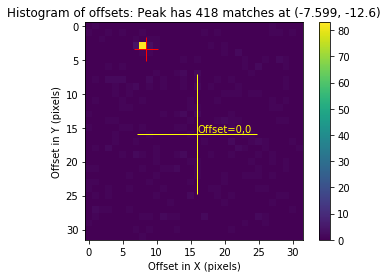

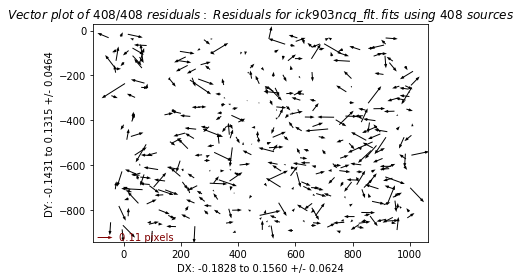

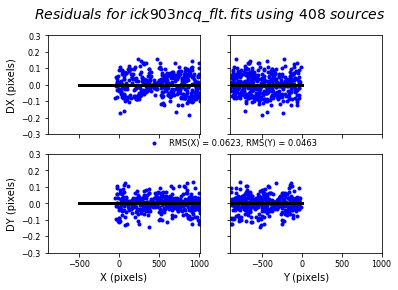

In [6]:
tweakreg.TweakReg('*flt.fits',
                  imagefindcfg={'threshold': 50, 'conv_width': 2.5},
                  expand_refcat=True,
                  enforce_user_order=False,
                  shiftfile=True,
                  outshifts='shift160_flt.txt',
                  searchrad=2.0,
                  ylimit=0.3,
                  updatehdr=True,
                  reusename=True,
                  wcsname='IR_FLT',
                  interactive=False)

## 4b. Inspect the shift file to verify the pointing residuals 

With the `threshold` parameter set to 50 sigma, TweakReg finds ~500 objects per FLC image, matches the individual catalogs, and computes residual shifts between exposures. These offsets (given in pixels at the native IR scale=0.1283”/pixel) are recorded in an output “shift file” which is shown below.  Note that the fourth row of the shift file corresponds to the reference image ‘ick902neq_flt.fits’ which was automatically selected by TweakReg. The computed offsets reflect updates to the header WCS required to correct for small pointing errors.

In [7]:
shift_table = Table.read('shift160_flt.txt',
                         format='ascii.no_header', 
                         names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

<Table length=8>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
ick901hzq_flt.fits   -0.16    0.42 359.999 1.00008    0.06    0.04
ick901i7q_flt.fits   -0.20    0.37 360.000 0.99993    0.06    0.05
ick902n9q_flt.fits    0.03    0.09 360.000 1.00000    0.06    0.04
ick902neq_flt.fits    0.00    0.00   0.000 1.00000    0.00    0.00
ick903n4q_flt.fits   -6.98  -11.97 359.999 0.99999    0.07    0.05
ick903ncq_flt.fits   -7.02  -12.04 359.999 1.00002    0.06    0.05
ick904obq_flt.fits   -8.75  -12.12 359.997 0.99992    0.05    0.04
ick904ogq_flt.fits   -8.79  -12.22 359.998 1.00007    0.06    0.04

The expected pointing accuracy for various observing scenerios is summarized in the DrizzlePac Handbook [Appendix B](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/AppendixB2.html). Exposures making up visit-level drizzled products are typically aligned to 2-5 milliarcsecond (mas) accuracy with fine-lock on 2 guide stars. The shift file above confirms this, with offsets (dx,dy) between pairs of exposures in the same visit visit averaging ~0.05 IR pixels (6 mas). For different visits using the same set of guide stars, offsets of ~50-100 mas (0.6-1.2 IR pixels are expected. For visits with different sets of guide stars, the pointing accuracy is typically 0.2-0.5 arcseconds. 

The cell below shows how to check the image header for the 'Dominant' and 'Secondary' guide stars used. Since the M16 tiles (visits) each used different guide star pairs, the relatively large offsets (>1 arcsec) required for visits 03 and 04 to match the visit 02 reference image are not surprising, though are larger than expected. Note that the TweakReg `searchrad` parameter was increased to 2.0" from the default value of 1.0" to allow TweakReg to find the correct fit for these visits.

In [8]:
collect_spt = ImageFileCollection('./', glob_include="ick9*0_spt.fits", ext=0,
                                  keywords=["asn_id", "config", "dgestar", "sgestar"])
table_spt = collect_spt.summary
table_spt

<Table masked=True length=8>
       file          asn_id    config    dgestar      sgestar   
      str18           str9      str9      str12        str12    
------------------ --------- --------- ------------ ------------
ick901030_spt.fits ICK901030   WFC3/IR S9KJ000767F1 S9KI000263F2
ick902030_spt.fits ICK902030   WFC3/IR S9KI000192F2 S9KJ000745F1
ick903030_spt.fits ICK903030   WFC3/IR S9KI000192F2 S9KJ000768F1
ick904030_spt.fits ICK904030   WFC3/IR S9KJ004094F1 S9KI009737F2
ick905040_spt.fits ICK905040 WFC3/UVIS S9KJ000767F1 S9KI000263F2
ick906040_spt.fits ICK906040 WFC3/UVIS S9KI000192F2 S9KJ000753F1
ick907040_spt.fits ICK907040 WFC3/UVIS S9KI000248F2 S9KJ003951F1
ick908040_spt.fits ICK908040 WFC3/UVIS S9KJ004094F1 S9KI009737F2

With `enforce_user_order='True'`, the FLC files were aligned in the order shown below. The exposure v02b was automatically selected as the reference and then v02a was selected as the image with the most overlap on the sky. The two input catalogs had 601 and 574 sources, respectively, and this gave 483 matches for the two exposures, after sigma-clipping. The reference catalog was then expanded by adding 73 new objects from the dithered exposure v02a to the matched catalog for a total of 674 sources. 

TweakReg next moved over to tile 04 and to align exposure v04a to the expanded catalog. In the overlap region between tiles, 63 matches were found along the upper edge of v04a. The reference catalog was expanded once again, adding the 411 sources from v04a to give a total of 1087 sources. Now when v04b is aligned, the number of matches is 388, since the expanded catalog now includes v04a. TweakReg continues in this way until all input frames are aligned to the expanded catalog, and the number of matches for each exposure is listed in the ascii table below. 

## 4c. Inspect the IR fits

To verify that TweakReg obtained a good fit between matched source catalogs, it is useful to inspect the results before updating the image header WCS. Below sources matched with the reference frame (v02b) are overplotted on the first input image (v02a). It can be useful to check that TweakReg locked onto stars and not hot pixels or other detector artifacts before proceeding. Next, the vector residuals plot is displayed and checked for any systematics. Finally, the 4-panel plot of fit residuals: dx, dy vs X and Y is inspected to verify that the residuals cluster around zero.   

Text(0.5, 1.0, 'Match: v02a to v02b(Ref)')

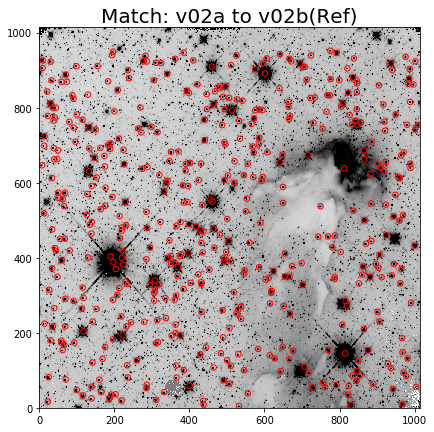

In [9]:
# v02a matches
plt.figure(figsize = (20, 7))
data = fits.open('ick902n9q_flt.fits')['SCI', 1].data
zscale = ZScaleInterval()
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick902n9q_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v02a to v02b(Ref)', fontsize=20)

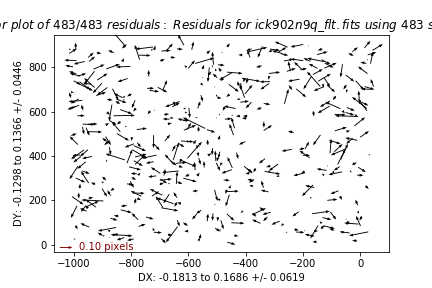

In [10]:
# v02a vector residuals
Image(filename='vector_ick902n9q_flt.png', width=500, height=300)

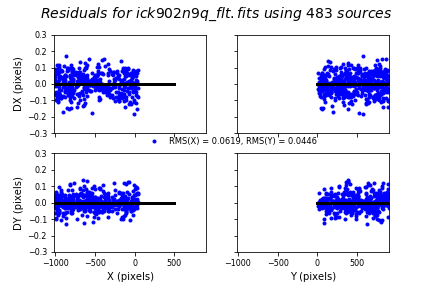

In [11]:
# v02a fit residuals
Image(filename='residuals_ick902n9q_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v04a to v02b(Ref)')

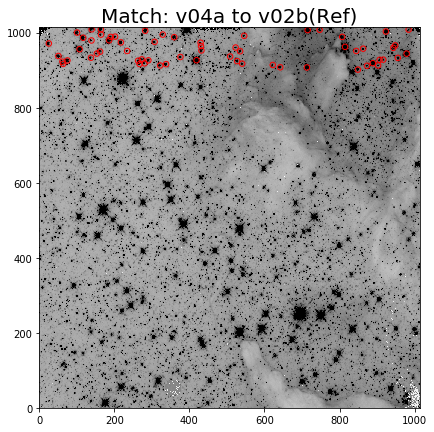

In [12]:
# v04a matches (Edge overlap region only)
plt.figure(figsize = (20, 7))
data = fits.open('ick904obq_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick904obq_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v04a to v02b(Ref)', fontsize=20)

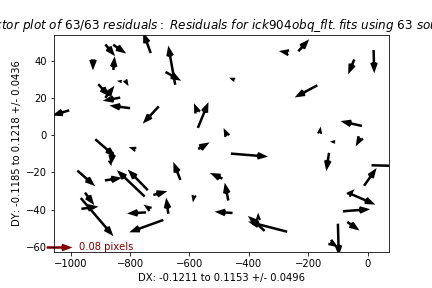

In [13]:
# v04a vector residuals (Edge gives narrow range of Y-values)
Image(filename='vector_ick904obq_flt.png', width=500, height=300)

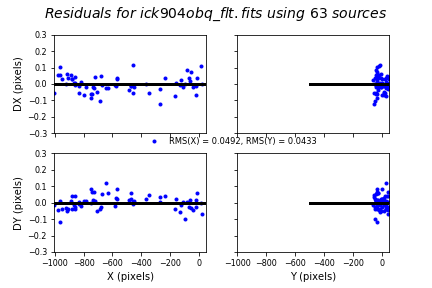

In [14]:
# v04a fit residuals (Edge gives narrow range of Y-values)
Image(filename='residuals_ick904obq_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v04b to v02b(Ref)')

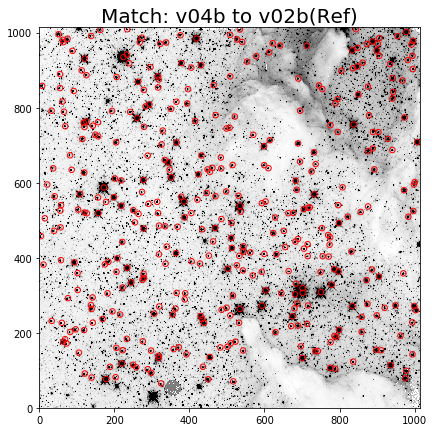

In [15]:
# v04b matches (Full image since v04a already aligned)
plt.figure(figsize = (20, 7))
data = fits.open('ick904ogq_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick904ogq_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v04b to v02b(Ref)', fontsize=20)

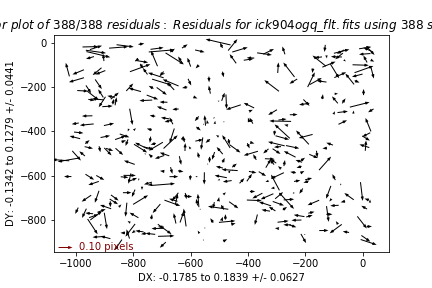

In [16]:
# v04b vector residuals
Image(filename='vector_ick904ogq_flt.png', width=500, height=300)

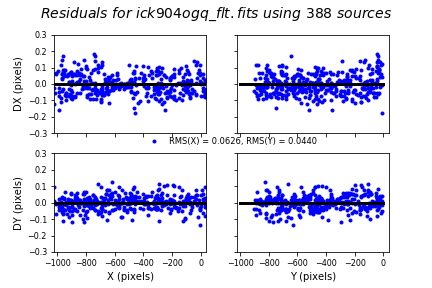

In [17]:
# v04b fit residuals
Image(filename='residuals_ick904ogq_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v01a to v02b(Ref)')

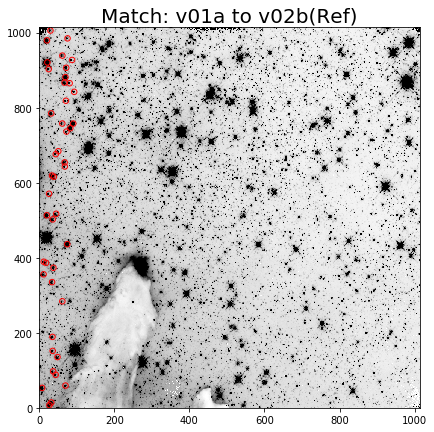

In [18]:
# v01a matches (Edge overlap region only)
plt.figure(figsize = (20, 7))
data = fits.open('ick901hzq_flt.fits')['SCI',1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin = 'lower', vmin = z1, vmax = z2)
match_tab = ascii.read('ick901hzq_flt_catalog_fit.match')                 #load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s = 30, edgecolor = 'r', facecolor = 'None')
plt.ylim(0,1014)
plt.xlim(0,1014)
plt.title('Match: v01a to v02b(Ref)', fontsize=20)

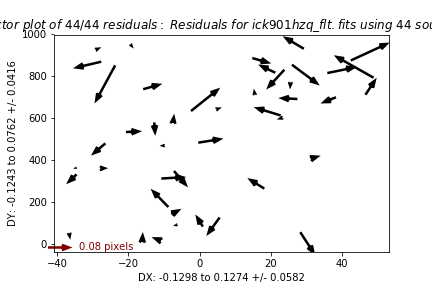

In [19]:
# v01a vector residuals (Left edge gives narrow range of X-values)
Image(filename='vector_ick901hzq_flt.png', width=500, height=300)

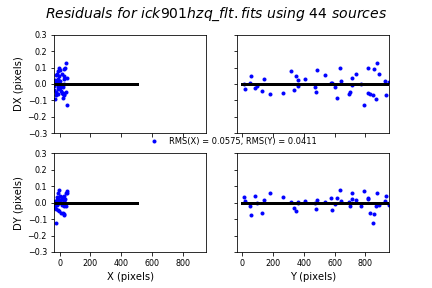

In [20]:
# v01a fit residuals (Left edge gives narrow range of X-values)
Image(filename='residuals_ick901hzq_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v01b to v02b(Ref)')

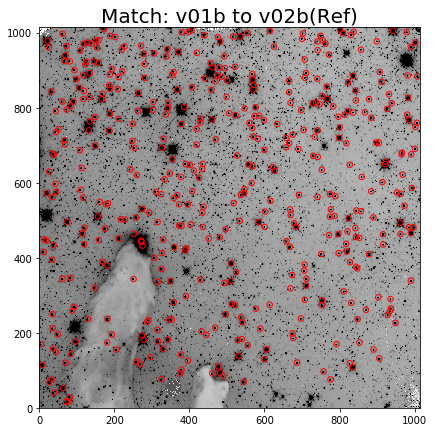

In [21]:
# v01b matches (Full image since v01a already aligned)

plt.figure(figsize = (20,7))
data = fits.open('ick901i7q_flt.fits')['SCI',1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin = 'lower', vmin = z1, vmax = z2)
match_tab = ascii.read('ick901i7q_flt_catalog_fit.match')                 #load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s = 30, edgecolor = 'r', facecolor = 'None')
plt.ylim(0,1014)
plt.xlim(0,1014)
plt.title('Match: v01b to v02b(Ref)', fontsize=20)

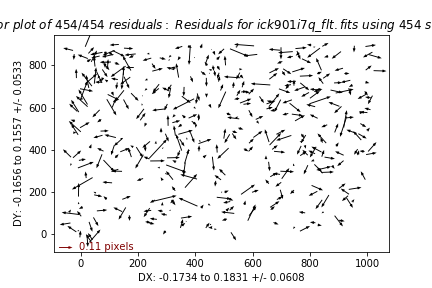

In [22]:
# v01b vector residuals
Image(filename='vector_ick901i7q_flt.png', width=500, height=300)

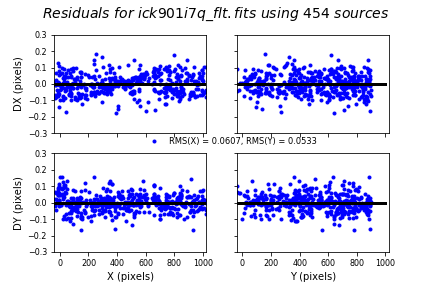

In [23]:
# v01b fit residuals
Image(filename='residuals_ick901i7q_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v03a to v02b(Ref)')

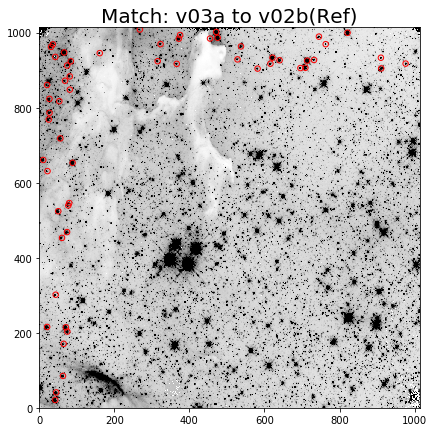

In [24]:
# v03a matches (Top and left edge overlap regions only)
plt.figure(figsize = (20, 7))
data = fits.open('ick903n4q_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick903n4q_flt_catalog_fit.match')  # load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v03a to v02b(Ref)', fontsize=20)

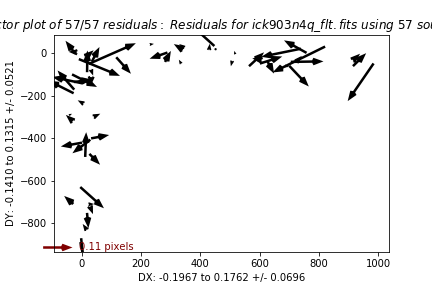

In [25]:
# v03a vector residuals (Top and left edges)
Image(filename='vector_ick903n4q_flt.png', width=500, height=300)

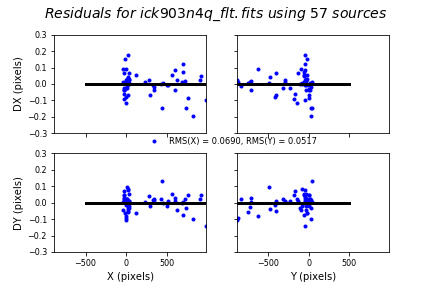

In [26]:
# v03a fit residuals
Image(filename='residuals_ick903n4q_flt.png', width=500, height=300)

Text(0.5, 1.0, 'Match: v03b to v02b(Ref)')

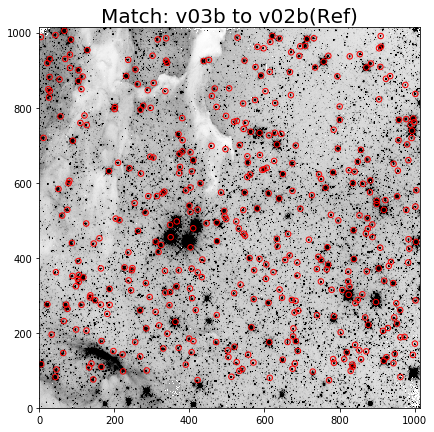

In [27]:
# v03b matches (Full image since v03a already aligned)
plt.figure(figsize = (20, 7))
data = fits.open('ick903ncq_flt.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(data)
plt.imshow(data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick903ncq_flt_catalog_fit.match')                 #load match file in astropy table
x_coord, y_coord = match_tab['col11'], match_tab['col12']
plt.scatter(x_coord, y_coord, s=30, edgecolor='r', facecolor='None')
plt.ylim(0, 1014)
plt.xlim(0, 1014)
plt.title('Match: v03b to v02b(Ref)', fontsize=20)

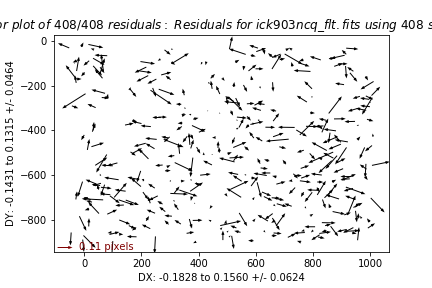

In [28]:
# v03b vector residuals
Image(filename='vector_ick903ncq_flt.png', width=500, height=300)

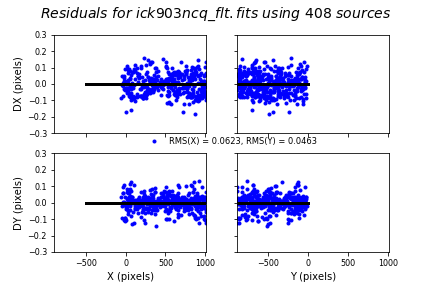

In [29]:
# v03b fit residuals
Image(filename='residuals_ick903ncq_flt.png', width=500, height=300)

The dx,dy residuals for all IR exposures are all clustered around dx,dy=0 and have an RMS less than 0.1 pixels, indicating a good fit. If the alignment needs to be fine-tuned, changing the parameters `threshold`, `sigma`, and `searchrad` may help TweakReg to lock onto an accurate solution. 

# 5. Mosaicking Features in AstroDrizzle

AstroDrizzle now makes it easier for users to match the sky background when tiling together large mosaics. In prior versions of the software, the sky background was based on clipped statistics in each image separately. The sky background was measured for each chip and the lowest sky value (in electrons/arcsec^2) among all of the chips was adopted. For observations of sparse fields, this approach generally works well. However, when large extended objects fill the detector, there is no true 'blank sky' and the background value will be an overestimate. Additionally, when extended targets are observed as mosaics (e.g. with large dithers), the 'scene' can change significantly between exposures and bias the background estimate.

An error in determining the sky background may in turn impact the cosmic ray rejection, and if severe enough, the resulting photometry. Additionally, by not properly matching the sky background before combining frames, correlated noise will be added to the final drizzled products when differences in the background levels are significant. Until now, the recommended workaround has been for users to give AstroDrizzle an ASCII file (`skyfile`) containing user-defined background values. 

AstroDrizzle now features several new options for computing the sky. One of these, `skymethod='match'`, is useful for “equalizing” the sky background across large mosaics. This method computes differences in sky values using only pixels in common between images. The sky values will then be set relative to the value computed for the input frame with the lowest sky value for which the MDRIZSKY keyword will be set to 0. In this way, the sky background is not removed, but instead equalized before the data are combined. For more details on the sky matching functions used by AstroDrizzle, see the following [webpage](https://stsci-skypac.readthedocs.io/en/latest/skymatch.html).

## 5a. Drizzle the IR/F160W Mosaic

Now AstroDrizzle can be used to combine the full set of F160W frames. In this case the final orientation has been set to -35 degrees so that the pillars will be oriented vertically. Note that users must first set the parameter `final_wcs='True'` in order to turn on parameters in AstroDrizzle’s step 7a: `Custom WCS for Final Output`. For these observations, the IR scale (0.08”/pixel) is chosen to be exactly twice that for the UVIS mosaics (0.04”/pixel) by setting `final_scale=0.08`, and the drizzled images have been oversized slightly to match the sky area on the sky covered by the UVIS. The sky background may be equalized across mosaic tiles by setting the parameter `skymethod='match'`.
   
The parameter `final_bits` defines which DQ flags in the FLT image to treat as good. All other pixels with non-zero DQ values will be assumed to be bad and rejected from the final mosaic. For IR data, these two parameters are typically set to 64+512 in the pipeline, corresponding to warm pixels and IR blobs. This program included a blob dither, however, and so the 512 flag may be removed from the list of good DQ values such that these pixels will be replaced with non-flagged pixels from the accompanying dithered pair. 

For IR data, cosmic-rays have already rejected via the 'up-the-ramp' fitting by calwf3, so Steps 3, 4, 5, 6 in AstroDrizzle have been turned off when combining the FLT exposures.  See [this reference](https://drizzlepac.readthedocs.io/en/deployment/astrodrizzle.html) for more information about the various input parameters to AstroDrizzle.

In [30]:
astrodrizzle.AstroDrizzle('*flt.fits',
                          output='f160w',
                          preserve=False,
                          clean=True,
                          build=False,
                          context=False,
                          skymethod='match', 
                          driz_separate=False,
                          median=False,
                          blot=False,
                          driz_cr=False,
                          final_bits='64',
                          final_wcs=True,
                          final_scale=0.08,
                          final_rot=-35,
                          final_ra=274.721587,
                          final_dec=-13.841549,
                          final_outnx=4000,
                          final_outny=4500)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 20:10:09.428 (20/03/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 20:10:09.428 (20/03/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 7.3.0]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:10:09.433 (20/03/2019)


==== Processing Step  Initialization  started at  20:10:09.433 (20/03/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_drz.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 4.605569684705086


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 4.734417357919567


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 5.970835604871715


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 5.96824573672076


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 6.092937117979282


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 6.043391503190651


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 5.897300450801163


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 5.851655709115792


INFO:drizzlepac.imageObject:No context image will be created for ick901hzq_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick901i7q_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick902n9q_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick902neq_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick903n4q_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick903ncq_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick904obq_flt.fits


INFO:drizzlepac.imageObject:No context image will be created for ick904ogq_flt.fits


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick901hzq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick901i7q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick902n9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick902neq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick903n4q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick903ncq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick904obq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ick904ogq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:drizzlepac.imageObject:No context image will be created for f160w_drz.fits


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 274.721587  -13.841549  


CRVAL : 274.721587  -13.841549  


INFO:astropy.wcs.wcs:CRPIX : 2000.5  2250.5  


CRPIX : 2000.5  2250.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -1.8203378761977594e-05  -1.2746143030023248e-05  


CD1_1 CD1_2  : -1.8203378761977594e-05  -1.2746143030023248e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -1.2746143030023248e-05  1.8203378761977594e-05  


CD2_1 CD2_2  : -1.2746143030023248e-05  1.8203378761977594e-05  


INFO:astropy.wcs.wcs:NAXIS : 4000  4500


NAXIS : 4000  4500


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 213 Mb.


*  Estimated memory usage:  up to 213 Mb.


INFO:drizzlepac.processInput:*  Output image size:       4000 X 4500 pixels. 


*  Output image size:       4000 X 4500 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 205 Mb. 


*  Output image file:       ~ 205 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:10:11.250 (20/03/2019)


==== Processing Step  Initialization  finished at  20:10:11.250 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	False


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:10:11.258 (20/03/2019)


==== Processing Step  Static Mask  started at  20:10:11.258 (20/03/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  4.643371;   rms = 2.243195;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  4.694508;   rms = 2.204900;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  5.881938;   rms = 3.506849;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  6.028995;   rms = 3.469234;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  6.060067;   rms = 2.187948;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  6.024473;   rms = 2.175039;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  5.874790;   rms = 2.044718;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  5.829114;   rms = 1.974843;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  20:10:11.559 (20/03/2019)


==== Processing Step  Static Mask  finished at  20:10:11.559 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:10:11.562 (20/03/2019)


==== Processing Step  Subtract Sky  started at  20:10:11.562 (20/03/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-03-20 20:10:11.837885


***** skymatch started on 2019-03-20 20:10:11.837885


INFO:stsci.skypac.utils:      Version 1.0.2 (2019-03-07 00:54:44 -0500)


      Version 1.0.2 (2019-03-07 00:54:44 -0500)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick901hzq_flt.fits'


   **  Input image: 'ick901hzq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick901hzq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick901hzq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick901i7q_flt.fits'


   **  Input image: 'ick901i7q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick901i7q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick901i7q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick902n9q_flt.fits'


   **  Input image: 'ick902n9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick902n9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick902n9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick902neq_flt.fits'


   **  Input image: 'ick902neq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick902neq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick902neq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick903n4q_flt.fits'


   **  Input image: 'ick903n4q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick903n4q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick903n4q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick903ncq_flt.fits'


   **  Input image: 'ick903ncq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick903ncq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick903ncq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick904obq_flt.fits'


   **  Input image: 'ick904obq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick904obq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick904obq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ick904ogq_flt.fits'


   **  Input image: 'ick904ogq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ick904ogq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ick904ogq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick901hzq_flt.fits


   *   Image: ick901hzq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick901i7q_flt.fits


   *   Image: ick901i7q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick902n9q_flt.fits


   *   Image: ick902n9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick902neq_flt.fits


   *   Image: ick902neq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick903n4q_flt.fits


   *   Image: ick903n4q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick903ncq_flt.fits


   *   Image: ick903ncq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick904obq_flt.fits


   *   Image: ick904obq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ick904ogq_flt.fits


   *   Image: ick904ogq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick901hzq_flt.fits['SCI',1]' SKY = 0.87829 [brightness units]


   *   Image 'ick901hzq_flt.fits['SCI',1]' SKY = 0.87829 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0144462


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0144462


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick901i7q_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ick901i7q_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick902n9q_flt.fits['SCI',1]' SKY = 5.15397 [brightness units]


   *   Image 'ick902n9q_flt.fits['SCI',1]' SKY = 5.15397 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0847728


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0847728


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick902neq_flt.fits['SCI',1]' SKY = 4.31913 [brightness units]


   *   Image 'ick902neq_flt.fits['SCI',1]' SKY = 4.31913 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0710413


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0710413


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick903n4q_flt.fits['SCI',1]' SKY = 6.13667 [brightness units]


   *   Image 'ick903n4q_flt.fits['SCI',1]' SKY = 6.13667 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.100936


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.100936


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick903ncq_flt.fits['SCI',1]' SKY = 3.72395 [brightness units]


   *   Image 'ick903ncq_flt.fits['SCI',1]' SKY = 3.72395 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0612518


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0612518


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick904obq_flt.fits['SCI',1]' SKY = 7.77628 [brightness units]


   *   Image 'ick904obq_flt.fits['SCI',1]' SKY = 7.77628 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.127905


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.127905


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ick904ogq_flt.fits['SCI',1]' SKY = 5.34565 [brightness units]


   *   Image 'ick904ogq_flt.fits['SCI',1]' SKY = 5.34565 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0879255


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0879255


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-03-20 20:10:16.631916


***** skymatch ended on 2019-03-20 20:10:16.631916


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:04.794031


TOTAL RUN TIME: 0:00:04.794031


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:10:16.855 (20/03/2019)


==== Processing Step  Subtract Sky  finished at  20:10:16.855 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:10:16.857 (20/03/2019)


==== Processing Step  Separate Drizzle  started at  20:10:16.857 (20/03/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:10:16.858 (20/03/2019)


==== Processing Step  Separate Drizzle  finished at  20:10:16.858 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:10:16.860 (20/03/2019)


==== Processing Step  Create Median  started at  20:10:16.860 (20/03/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:10:16.861 (20/03/2019)


==== Processing Step  Blot  started at  20:10:16.861 (20/03/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:10:16.862 (20/03/2019)


==== Processing Step  Blot  finished at  20:10:16.862 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:10:16.864 (20/03/2019)


==== Processing Step  Driz_CR  started at  20:10:16.864 (20/03/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:10:16.866 (20/03/2019)


==== Processing Step  Final Drizzle  started at  20:10:16.866 (20/03/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 274.721587  -13.841549  


CRVAL : 274.721587  -13.841549  


INFO:astropy.wcs.wcs:CRPIX : 2000.5  2250.5  


CRPIX : 2000.5  2250.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -1.8203378761977594e-05  -1.2746143030023248e-05  


CD1_1 CD1_2  : -1.8203378761977594e-05  -1.2746143030023248e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -1.2746143030023248e-05  1.8203378761977594e-05  


CD2_1 CD2_2  : -1.2746143030023248e-05  1.8203378761977594e-05  


INFO:astropy.wcs.wcs:NAXIS : 4000  4500


NAXIS : 4000  4500


INFO:drizzlepac.adrizzle:-Drizzle input: ick901hzq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.014446 to ick901hzq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick901i7q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ick901i7q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick902n9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.084773 to ick902n9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick902neq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.071041 to ick902neq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick903n4q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.100936 to ick903n4q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick903ncq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.061252 to ick903ncq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick904obq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.127905 to ick904obq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick904ogq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.087926 to ick904ogq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_drz_sci.fits


-Generating simple FITS output: f160w_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_drz_sci.fits


Writing out image to disk: f160w_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_drz_wht.fits


Writing out image to disk: f160w_drz_wht.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:10:22.687 (20/03/2019)


==== Processing Step  Final Drizzle  finished at  20:10:22.687 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 20:10:22.690 (20/03/2019).


AstroDrizzle Version 2.2.6 is finished processing at 20:10:22.690 (20/03/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          1.8166 sec.


         Initialization          1.8166 sec.


INFO:drizzlepac.util:            Static Mask          0.3013 sec.


            Static Mask          0.3013 sec.


INFO:drizzlepac.util:           Subtract Sky          5.2931 sec.


           Subtract Sky          5.2931 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0014 sec.


       Separate Drizzle          0.0014 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0013 sec.


                   Blot          0.0013 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          5.8212 sec.


          Final Drizzle          5.8212 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          13.2348 sec.


                  Total          13.2348 sec.


INFO:drizzlepac.imageObject:Removing intermediate files for ick901hzq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick901i7q_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick902n9q_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick902neq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick903n4q_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick903ncq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick904obq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ick904ogq_flt.fits


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


## 5b. Display the combined DRZ science and weight images 

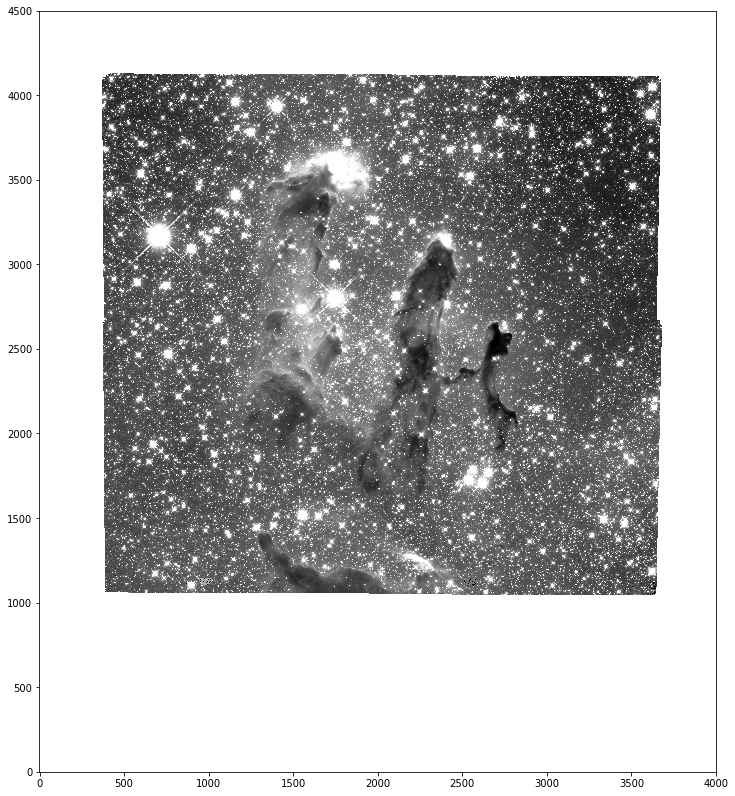

In [31]:
sci = fits.getdata('f160w_drz_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=1, vmax=6, cmap='Greys_r', origin='lower')

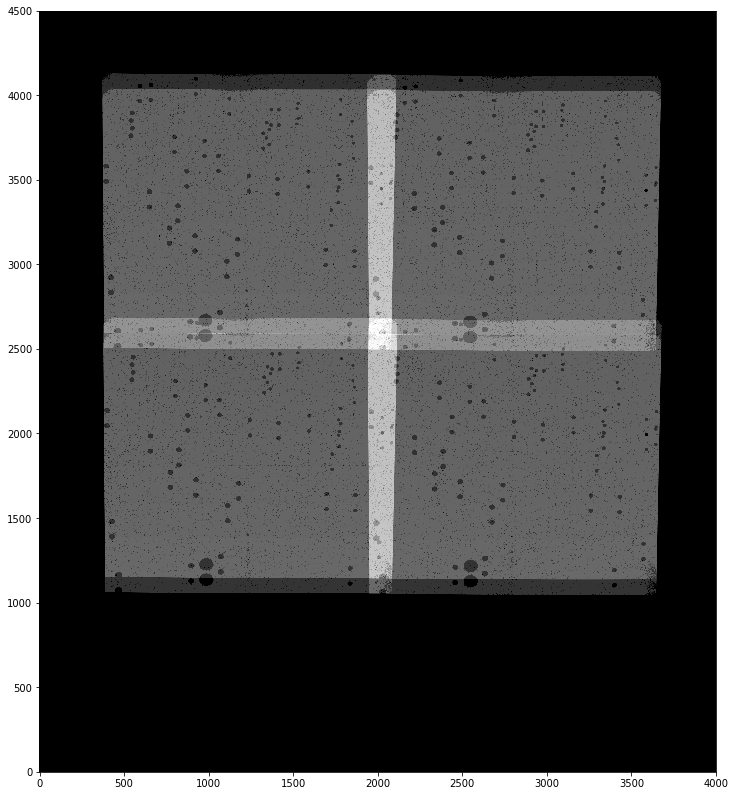

In [32]:
wht = fits.getdata('f160w_drz_wht.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(wht, vmin=0, vmax=1700, cmap='Greys_r', origin='lower')

# 6. Align the UVIS FLC frames to the IR mosaic

The F160W drizzled mosaic defines the reference frame for aligning the UVIS filters. In [ISR 2015-09](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-09.pdf), the UVIS visit-level DRC frames were aligned directly to the IR reference image, and this approach was chosen because the long UVIS exposures contain numerous cosmic-rays and relatively few point sources. The Drizzlepac task TweakBack was then used to propagate the updated WCS from the drizzled image header back to the individual FLC input frames making up each association prior to drizzling.

In this notebook, the FLC frames may be aligned directly to the IR mosaic by making use of a new parameter in TweakReg which allows for specific flags in the DQ array of the FLC frames to be used or ignored. The `imagefindpars` parameter `dqbits` may be prepended with ‘~’ to the string value to indicate which DQ flags to consider as "bad" pixels. For example, when deriving source catalogs, Tweakreg will ignore any pixels flagged as cosmic-ray flags in the MAST visit-level drizzled data products when `dqbits` is set to ~4096. This dramatically cuts down the number of false detections due to cosmic rays in the input FLC science arrays. More details on `imagefindpars` options may be found on the following [webpage](https://drizzlepac.readthedocs.io/en/deployment/imagefindpars.html). 

In this example, the `threshold` value was manually adjusted to get ~50 matches per UVIS exposure. Note that setting the `threshold` to a very low value does not necessarily translate to a better solution, since all sources are weighted equally when computing fits to match catalogs. This is especially relevant for UVIS data where CTE tails can shift the centroid position slightly along the readout direction for faint sources and potentially bias the fit.

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 20:10:24.816 (20/03/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 20:10:24.816 (20/03/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 7.3.0]


Python Version [GCC 7.3.0]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	False


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	input :	*_flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	f160w_drz_sci.fits


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ick905k5q_flc.fits


    ick905k5q_flc.fits


INFO:drizzlepac.tweakreg:    ick905keq_flc.fits


    ick905keq_flc.fits


INFO:drizzlepac.tweakreg:    ick905knq_flc.fits


    ick905knq_flc.fits


INFO:drizzlepac.tweakreg:    ick906kwq_flc.fits


    ick906kwq_flc.fits


INFO:drizzlepac.tweakreg:    ick906l5q_flc.fits


    ick906l5q_flc.fits


INFO:drizzlepac.tweakreg:    ick906leq_flc.fits


    ick906leq_flc.fits


INFO:drizzlepac.tweakreg:    ick907nkq_flc.fits


    ick907nkq_flc.fits


INFO:drizzlepac.tweakreg:    ick907o1q_flc.fits


    ick907o1q_flc.fits


INFO:drizzlepac.tweakreg:    ick907ouq_flc.fits


    ick907ouq_flc.fits


INFO:drizzlepac.tweakreg:    ick908pbq_flc.fits


    ick908pbq_flc.fits


INFO:drizzlepac.tweakreg:    ick908pkq_flc.fits


    ick908pkq_flc.fits


INFO:drizzlepac.tweakreg:    ick908ptq_flc.fits


    ick908ptq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	3.5


INFO:drizzlepac.tweakreg:	dqbits :	-4097


INFO:drizzlepac.tweakreg:	enforce_user_order :	False


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*_flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	f160w_drz_sci.fits


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	200


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick905k5q_flc.fits':


===  Source finding for image 'ick905k5q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905k5q_flc.fits', EXT=('SCI', 1) started at: 20:10:24.977 (20/03/2019)


  #  Source finding for 'ick905k5q_flc.fits', EXT=('SCI', 1) started at: 20:10:24.977 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.914108


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:25.694 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 148 objects.


     Found 148 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905k5q_flc.fits', EXT=('SCI', 2) started at: 20:10:25.784 (20/03/2019)


  #  Source finding for 'ick905k5q_flc.fits', EXT=('SCI', 2) started at: 20:10:25.784 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 11.987140


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:26.50 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 574 objects.


     Found 574 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick905k5q_flc.fits': 722


===  FINAL number of objects in image 'ick905k5q_flc.fits': 722


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick905keq_flc.fits':


===  Source finding for image 'ick905keq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905keq_flc.fits', EXT=('SCI', 1) started at: 20:10:26.746 (20/03/2019)


  #  Source finding for 'ick905keq_flc.fits', EXT=('SCI', 1) started at: 20:10:26.746 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.909635


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:27.487 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 89 objects.


     Found 89 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905keq_flc.fits', EXT=('SCI', 2) started at: 20:10:27.576 (20/03/2019)


  #  Source finding for 'ick905keq_flc.fits', EXT=('SCI', 2) started at: 20:10:27.576 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.073435


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:28.303 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 215 objects.


     Found 215 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick905keq_flc.fits': 304


===  FINAL number of objects in image 'ick905keq_flc.fits': 304


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick905knq_flc.fits':


===  Source finding for image 'ick905knq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905knq_flc.fits', EXT=('SCI', 1) started at: 20:10:28.641 (20/03/2019)


  #  Source finding for 'ick905knq_flc.fits', EXT=('SCI', 1) started at: 20:10:28.641 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.029766


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:29.386 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 258 objects.


     Found 258 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick905knq_flc.fits', EXT=('SCI', 2) started at: 20:10:29.472 (20/03/2019)


  #  Source finding for 'ick905knq_flc.fits', EXT=('SCI', 2) started at: 20:10:29.472 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 12.057777


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:30.182 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 213 objects.


     Found 213 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick905knq_flc.fits': 471


===  FINAL number of objects in image 'ick905knq_flc.fits': 471


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick906kwq_flc.fits':


===  Source finding for image 'ick906kwq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906kwq_flc.fits', EXT=('SCI', 1) started at: 20:10:30.49 (20/03/2019)


  #  Source finding for 'ick906kwq_flc.fits', EXT=('SCI', 1) started at: 20:10:30.49 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.643072


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:31.169 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 186 objects.


     Found 186 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906kwq_flc.fits', EXT=('SCI', 2) started at: 20:10:31.252 (20/03/2019)


  #  Source finding for 'ick906kwq_flc.fits', EXT=('SCI', 2) started at: 20:10:31.252 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.414701


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:31.955 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 338 objects.


     Found 338 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick906kwq_flc.fits': 524


===  FINAL number of objects in image 'ick906kwq_flc.fits': 524


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick906l5q_flc.fits':


===  Source finding for image 'ick906l5q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906l5q_flc.fits', EXT=('SCI', 1) started at: 20:10:32.165 (20/03/2019)


  #  Source finding for 'ick906l5q_flc.fits', EXT=('SCI', 1) started at: 20:10:32.165 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.631145


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:32.848 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 94 objects.


     Found 94 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906l5q_flc.fits', EXT=('SCI', 2) started at: 20:10:32.931 (20/03/2019)


  #  Source finding for 'ick906l5q_flc.fits', EXT=('SCI', 2) started at: 20:10:32.931 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 15.561554


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:33.584 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 130 objects.


     Found 130 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick906l5q_flc.fits': 224


===  FINAL number of objects in image 'ick906l5q_flc.fits': 224


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick906leq_flc.fits':


===  Source finding for image 'ick906leq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906leq_flc.fits', EXT=('SCI', 1) started at: 20:10:33.788 (20/03/2019)


  #  Source finding for 'ick906leq_flc.fits', EXT=('SCI', 1) started at: 20:10:33.788 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 16.691345


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:34.450 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 242 objects.


     Found 242 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick906leq_flc.fits', EXT=('SCI', 2) started at: 20:10:34.528 (20/03/2019)


  #  Source finding for 'ick906leq_flc.fits', EXT=('SCI', 2) started at: 20:10:34.528 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 14.747993


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:35.191 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 186 objects.


     Found 186 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick906leq_flc.fits': 428


===  FINAL number of objects in image 'ick906leq_flc.fits': 428


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick907nkq_flc.fits':


===  Source finding for image 'ick907nkq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907nkq_flc.fits', EXT=('SCI', 1) started at: 20:10:35.43 (20/03/2019)


  #  Source finding for 'ick907nkq_flc.fits', EXT=('SCI', 1) started at: 20:10:35.43 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.998682


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:36.189 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 111 objects.


     Found 111 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907nkq_flc.fits', EXT=('SCI', 2) started at: 20:10:36.282 (20/03/2019)


  #  Source finding for 'ick907nkq_flc.fits', EXT=('SCI', 2) started at: 20:10:36.282 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.788088


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:36.960 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 303 objects.


     Found 303 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick907nkq_flc.fits': 414


===  FINAL number of objects in image 'ick907nkq_flc.fits': 414


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick907o1q_flc.fits':


===  Source finding for image 'ick907o1q_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907o1q_flc.fits', EXT=('SCI', 1) started at: 20:10:37.199 (20/03/2019)


  #  Source finding for 'ick907o1q_flc.fits', EXT=('SCI', 1) started at: 20:10:37.199 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 18.056701


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:37.859 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 88 objects.


     Found 88 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907o1q_flc.fits', EXT=('SCI', 2) started at: 20:10:37.949 (20/03/2019)


  #  Source finding for 'ick907o1q_flc.fits', EXT=('SCI', 2) started at: 20:10:37.949 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.742237


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:38.699 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 101 objects.


     Found 101 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick907o1q_flc.fits': 189


===  FINAL number of objects in image 'ick907o1q_flc.fits': 189


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick907ouq_flc.fits':


===  Source finding for image 'ick907ouq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907ouq_flc.fits', EXT=('SCI', 1) started at: 20:10:38.955 (20/03/2019)


  #  Source finding for 'ick907ouq_flc.fits', EXT=('SCI', 1) started at: 20:10:38.955 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.942683


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:39.653 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 262 objects.


     Found 262 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick907ouq_flc.fits', EXT=('SCI', 2) started at: 20:10:39.743 (20/03/2019)


  #  Source finding for 'ick907ouq_flc.fits', EXT=('SCI', 2) started at: 20:10:39.743 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.810923


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:40.440 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 143 objects.


     Found 143 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick907ouq_flc.fits': 405


===  FINAL number of objects in image 'ick907ouq_flc.fits': 405


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick908pbq_flc.fits':


===  Source finding for image 'ick908pbq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908pbq_flc.fits', EXT=('SCI', 1) started at: 20:10:40.667 (20/03/2019)


  #  Source finding for 'ick908pbq_flc.fits', EXT=('SCI', 1) started at: 20:10:40.667 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 18.698361


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:41.348 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 119 objects.


     Found 119 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908pbq_flc.fits', EXT=('SCI', 2) started at: 20:10:41.43 (20/03/2019)


  #  Source finding for 'ick908pbq_flc.fits', EXT=('SCI', 2) started at: 20:10:41.43 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.107899


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:42.149 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 318 objects.


     Found 318 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick908pbq_flc.fits': 437


===  FINAL number of objects in image 'ick908pbq_flc.fits': 437


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick908pkq_flc.fits':


===  Source finding for image 'ick908pkq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908pkq_flc.fits', EXT=('SCI', 1) started at: 20:10:42.419 (20/03/2019)


  #  Source finding for 'ick908pkq_flc.fits', EXT=('SCI', 1) started at: 20:10:42.419 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 18.178764


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:43.078 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 57 objects.


     Found 57 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908pkq_flc.fits', EXT=('SCI', 2) started at: 20:10:43.158 (20/03/2019)


  #  Source finding for 'ick908pkq_flc.fits', EXT=('SCI', 2) started at: 20:10:43.158 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.168670


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:43.882 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 93 objects.


     Found 93 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick908pkq_flc.fits': 150


===  FINAL number of objects in image 'ick908pkq_flc.fits': 150


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ick908ptq_flc.fits':


===  Source finding for image 'ick908ptq_flc.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908ptq_flc.fits', EXT=('SCI', 1) started at: 20:10:44.084 (20/03/2019)


  #  Source finding for 'ick908ptq_flc.fits', EXT=('SCI', 1) started at: 20:10:44.084 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 18.100852


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:44.752 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 182 objects.


     Found 182 objects.


INFO:drizzlepac.catalogs:  #  Source finding for 'ick908ptq_flc.fits', EXT=('SCI', 2) started at: 20:10:44.829 (20/03/2019)


  #  Source finding for 'ick908ptq_flc.fits', EXT=('SCI', 2) started at: 20:10:44.829 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 17.383158


INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:45.487 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 116 objects.


     Found 116 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ick908ptq_flc.fits': 298


===  FINAL number of objects in image 'ick908ptq_flc.fits': 298


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	2.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	False


INFO:drizzlepac.tweakreg:	expand_refcat :	False


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	*_flc.fits


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	None


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	f160w_drz_sci.fits


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	50


INFO:drizzlepac.tweakreg:	updatehdr :	False


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.imgclasses:===  Source finding for image 'f160w_drz_sci.fits':


===  Source finding for image 'f160w_drz_sci.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'f160w_drz_sci.fits', EXT=0 started at: 20:10:45.811 (20/03/2019)


  #  Source finding for 'f160w_drz_sci.fits', EXT=0 started at: 20:10:45.811 (20/03/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 2.129812


  tdata=np.where(convdata > threshold, convdata, 0)



INFO:drizzlepac.catalogs:###Source finding finished at: 20:10:47.34 (20/03/2019)


INFO:drizzlepac.catalogs:     Found 1439 objects.


     Found 1439 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'f160w_drz_sci.fits': 1439


===  FINAL number of objects in image 'f160w_drz_sci.fits': 1439


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "f160w_drz_sci.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'f160w_drz_sci.fits'


derived from 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	5.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	15


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	0.6


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	shift657_flc.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick905k5q_flc.fits


Performing fit for: ick905k5q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick905k5q_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick905k5q_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -1.4655172413810789 -0.8275862068983244


Found initial X and Y shifts of  -1.4655172413810789 -0.8275862068983244


INFO:drizzlepac.tweakutils:    with significance of  1769.7129710775137 and  41.0  matches


    with significance of  1769.7129710775137 and  41.0  matches


INFO:drizzlepac.imgclasses:Found 57 matches for ick905k5q_flc.fits...


Found 57 matches for ick905k5q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick905k5q_flc.fits : 


Computed  rscale  fit for  ick905k5q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.9981  YSH: -0.5572    ROT: 359.9925387    SCALE: 1.000041


XSH: -0.9981  YSH: -0.5572    ROT: 359.9925387    SCALE: 1.000041


INFO:drizzlepac.imgclasses:XRMS: 0.17    YRMS: 0.11


XRMS: 0.17    YRMS: 0.11


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.5e-06 (deg)   RMS_DEC: 2.1e-07 (deg)


RMS_RA: 4.5e-06 (deg)   RMS_DEC: 2.1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  56  objects.


Final solution based on  56  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick905k5q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick905k5q_flc_catalog_fit.match


wrote XY data to:  ick905k5q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  56


Total # points:  56


INFO:drizzlepac.tweakutils:# of points after clipping:  56


# of points after clipping:  56


INFO:drizzlepac.tweakutils:Total # points:  56


Total # points:  56


INFO:drizzlepac.tweakutils:# of points after clipping:  56


# of points after clipping:  56


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick905k5q_flc.fits...


....Updating header for ick905k5q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick905k5q_flc.fits['SCI',1]


Processing ick905k5q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ick905k5q_flc.fits[1]


Updating header for ick905k5q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.422695341207057e-06 -6.3876415849698075e-06


CD_11  CD_12: -9.422695341207057e-06 -6.3876415849698075e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.806128223778022e-06 9.0363115012524e-06


CD_21  CD_22: -5.806128223778022e-06 9.0363115012524e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.69645042410866 -13.841208840856279


CRVAL    : 274.69645042410866 -13.841208840856279


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984607690545673


Plate Scale : 0.03984607690545673


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.255953441723946


ORIENTAT : -35.255953441723946


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick905k5q_flc.fits['SCI',2]


Processing ick905k5q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick905k5q_flc.fits[4]


Updating header for ick905k5q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.40808412898624e-06 -6.301434450168959e-06


CD_11  CD_12: -9.40808412898624e-06 -6.301434450168959e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.712791279709883e-06 8.937137998376887e-06


CD_21  CD_22: -5.712791279709883e-06 8.937137998376887e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.6828549634209 -13.822493887047997


CRVAL    : 274.6828549634209 -13.822493887047997


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962585958735084


Plate Scale : 0.03962585958735084


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.18705760767099


ORIENTAT : -35.18705760767099


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick905keq_flc.fits


Performing fit for: ick905keq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick905keq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick905keq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -1.451612903227577 -0.9032258064533849


Found initial X and Y shifts of  -1.451612903227577 -0.9032258064533849


INFO:drizzlepac.tweakutils:    with significance of  1626.398902884636 and  39.0  matches


    with significance of  1626.398902884636 and  39.0  matches


INFO:drizzlepac.imgclasses:Found 61 matches for ick905keq_flc.fits...


Found 61 matches for ick905keq_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick905keq_flc.fits : 


Computed  rscale  fit for  ick905keq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.9718  YSH: -0.5639    ROT: 359.9929289    SCALE: 1.000028


XSH: -0.9718  YSH: -0.5639    ROT: 359.9929289    SCALE: 1.000028


INFO:drizzlepac.imgclasses:XRMS: 0.17    YRMS: 0.1


XRMS: 0.17    YRMS: 0.1


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.5e-06 (deg)   RMS_DEC: 2.2e-07 (deg)


RMS_RA: 4.5e-06 (deg)   RMS_DEC: 2.2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  60  objects.


Final solution based on  60  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick905keq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick905keq_flc_catalog_fit.match


wrote XY data to:  ick905keq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  60


Total # points:  60


INFO:drizzlepac.tweakutils:# of points after clipping:  60


# of points after clipping:  60


INFO:drizzlepac.tweakutils:Total # points:  60


Total # points:  60


INFO:drizzlepac.tweakutils:# of points after clipping:  60


# of points after clipping:  60


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick905keq_flc.fits...


....Updating header for ick905keq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick905keq_flc.fits['SCI',1]


Processing ick905keq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick905keq_flc.fits[1]


Updating header for ick905keq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.422839183374287e-06 -6.387809766389773e-06


CD_11  CD_12: -9.422839183374287e-06 -6.387809766389773e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.806287667347885e-06 9.036444955583856e-06


CD_21  CD_22: -5.806287667347885e-06 9.036444955583856e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.6994286713105 -13.84286611719553


CRVAL    : 274.6994286713105 -13.84286611719553


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984629117496233


Plate Scale : 0.03984629117496233


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.25626564700697


ORIENTAT : -35.25626564700697


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick905keq_flc.fits['SCI',2]


Processing ick905keq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick905keq_flc.fits[4]


Updating header for ick905keq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.40822818832245e-06 -6.301600342580499e-06


CD_11  CD_12: -9.40822818832245e-06 -6.301600342580499e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.712948825188986e-06 8.93727011943095e-06


CD_21  CD_22: -5.712948825188986e-06 8.93727011943095e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.68583275574025 -13.824150886801235


CRVAL    : 274.68583275574025 -13.824150886801235


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039626072484136195


Plate Scale : 0.039626072484136195


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.18736906726492


ORIENTAT : -35.18736906726492


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick905knq_flc.fits


Performing fit for: ick905knq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick905knq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick905knq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -1.6216216216233903 -0.8108108108125833


Found initial X and Y shifts of  -1.6216216216233903 -0.8108108108125833


INFO:drizzlepac.tweakutils:    with significance of  1645.7203210144792 and  42.0  matches


    with significance of  1645.7203210144792 and  42.0  matches


INFO:drizzlepac.imgclasses:Found 69 matches for ick905knq_flc.fits...


Found 69 matches for ick905knq_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick905knq_flc.fits : 


Computed  rscale  fit for  ick905knq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.9385  YSH: -0.6008    ROT: 359.9919537    SCALE: 1.000038


XSH: -0.9385  YSH: -0.6008    ROT: 359.9919537    SCALE: 1.000038


INFO:drizzlepac.imgclasses:XRMS: 0.16    YRMS: 0.1


XRMS: 0.16    YRMS: 0.1


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.4e-06 (deg)   RMS_DEC: 2.2e-07 (deg)


RMS_RA: 4.4e-06 (deg)   RMS_DEC: 2.2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  67  objects.


Final solution based on  67  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick905knq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick905knq_flc_catalog_fit.match


wrote XY data to:  ick905knq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  67


Total # points:  67


INFO:drizzlepac.tweakutils:# of points after clipping:  67


# of points after clipping:  67


INFO:drizzlepac.tweakutils:Total # points:  67


Total # points:  67


INFO:drizzlepac.tweakutils:# of points after clipping:  67


# of points after clipping:  67


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick905knq_flc.fits...


....Updating header for ick905knq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick905knq_flc.fits['SCI',1]


Processing ick905knq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick905knq_flc.fits[1]


Updating header for ick905knq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.422576149016656e-06 -6.388004266798518e-06


CD_11  CD_12: -9.422576149016656e-06 -6.388004266798518e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.806499218807207e-06 9.036169146683033e-06


CD_21  CD_22: -5.806499218807207e-06 9.036169146683033e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.70240726066424 -13.84452318304139


CRVAL    : 274.70240726066424 -13.84452318304139


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984628998363555


Plate Scale : 0.03984628998363555


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.25791228131867


ORIENTAT : -35.25791228131867


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick905knq_flc.fits['SCI',2]


Processing ick905knq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick905knq_flc.fits[4]


Updating header for ick905knq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.407968077320484e-06 -6.301792841470927e-06


CD_11  CD_12: -9.407968077320484e-06 -6.301792841470927e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.713160817460523e-06 8.936997882526848e-06


CD_21  CD_22: -5.713160817460523e-06 8.936997882526848e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.688810833159 -13.825808522939205


CRVAL    : 274.688810833159 -13.825808522939205


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962607142126486


Plate Scale : 0.03962607142126486


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.18901531960207


ORIENTAT : -35.18901531960207


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick906kwq_flc.fits


Performing fit for: ick906kwq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick906kwq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick906kwq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -12.669642857144623 -21.25000000000177


Found initial X and Y shifts of  -12.669642857144623 -21.25000000000177


INFO:drizzlepac.tweakutils:    with significance of  1649.133803355526 and  39.0  matches


    with significance of  1649.133803355526 and  39.0  matches


INFO:drizzlepac.imgclasses:Found 77 matches for ick906kwq_flc.fits...


Found 77 matches for ick906kwq_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick906kwq_flc.fits : 


Computed  rscale  fit for  ick906kwq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -12.0111  YSH: -20.5468    ROT: 359.9903694    SCALE: 1.000049


XSH: -12.0111  YSH: -20.5468    ROT: 359.9903694    SCALE: 1.000049


INFO:drizzlepac.imgclasses:XRMS: 0.17    YRMS: 0.21


XRMS: 0.17    YRMS: 0.21


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.9e-06 (deg)   RMS_DEC: 1.8e-06 (deg)


RMS_RA: 5.9e-06 (deg)   RMS_DEC: 1.8e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  69  objects.


Final solution based on  69  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick906kwq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick906kwq_flc_catalog_fit.match


wrote XY data to:  ick906kwq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  69


Total # points:  69


INFO:drizzlepac.tweakutils:# of points after clipping:  69


# of points after clipping:  69


INFO:drizzlepac.tweakutils:Total # points:  69


Total # points:  69


INFO:drizzlepac.tweakutils:# of points after clipping:  69


# of points after clipping:  69


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick906kwq_flc.fits...


....Updating header for ick906kwq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick906kwq_flc.fits['SCI',1]


Processing ick906kwq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick906kwq_flc.fits[1]


Updating header for ick906kwq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.421645812277952e-06 -6.389115566481911e-06


CD_11  CD_12: -9.421645812277952e-06 -6.389115566481911e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.807671682218258e-06 9.035166925107655e-06


CD_21  CD_22: -5.807671682218258e-06 9.035166925107655e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7280638130588 -13.822135852001042


CRVAL    : 274.7280638130588 -13.822135852001042


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984607342164994


Plate Scale : 0.03984607342164994


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.26560622170421


ORIENTAT : -35.26560622170421


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick906kwq_flc.fits['SCI',2]


Processing ick906kwq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick906kwq_flc.fits[4]


Updating header for ick906kwq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.407049988042023e-06 -6.302892931777362e-06


CD_11  CD_12: -9.407049988042023e-06 -6.302892931777362e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.714333638163423e-06 8.93600819804221e-06


CD_21  CD_22: -5.714333638163423e-06 8.93600819804221e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.71446632131943 -13.803423264493276


CRVAL    : 274.71446632131943 -13.803423264493276


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0396258560720101


Plate Scale : 0.0396258560720101


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.19671427060735


ORIENTAT : -35.19671427060735


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick906l5q_flc.fits


Performing fit for: ick906l5q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick906l5q_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick906l5q_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -12.742105263159665 -21.16315789473861


Found initial X and Y shifts of  -12.742105263159665 -21.16315789473861


INFO:drizzlepac.tweakutils:    with significance of  1657.3767212537548 and  43.0  matches


    with significance of  1657.3767212537548 and  43.0  matches


INFO:drizzlepac.imgclasses:Found 71 matches for ick906l5q_flc.fits...


Found 71 matches for ick906l5q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick906l5q_flc.fits : 


Computed  rscale  fit for  ick906l5q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -11.9572  YSH: -20.5493    ROT: 359.9897429    SCALE: 1.000059


XSH: -11.9572  YSH: -20.5493    ROT: 359.9897429    SCALE: 1.000059


INFO:drizzlepac.imgclasses:XRMS: 0.17    YRMS: 0.2


XRMS: 0.17    YRMS: 0.2


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.7e-06 (deg)   RMS_DEC: 1.5e-06 (deg)


RMS_RA: 5.7e-06 (deg)   RMS_DEC: 1.5e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  68  objects.


Final solution based on  68  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick906l5q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick906l5q_flc_catalog_fit.match


wrote XY data to:  ick906l5q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  68


Total # points:  68


INFO:drizzlepac.tweakutils:# of points after clipping:  68


# of points after clipping:  68


INFO:drizzlepac.tweakutils:Total # points:  68


Total # points:  68


INFO:drizzlepac.tweakutils:# of points after clipping:  68


# of points after clipping:  68


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick906l5q_flc.fits...


....Updating header for ick906l5q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick906l5q_flc.fits['SCI',1]


Processing ick906l5q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick906l5q_flc.fits[1]


Updating header for ick906l5q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.421467880558343e-06 -6.389295732487886e-06


CD_11  CD_12: -9.421467880558343e-06 -6.389295732487886e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.807863534659626e-06 9.03497722067227e-06


CD_21  CD_22: -5.807863534659626e-06 9.03497722067227e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.73104266432125 -13.823792556832716


CRVAL    : 274.73104266432125 -13.823792556832716


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039846287847107184


Plate Scale : 0.039846287847107184


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.266934982978725


ORIENTAT : -35.266934982978725


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick906l5q_flc.fits['SCI',2]


Processing ick906l5q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick906l5q_flc.fits[4]


Updating header for ick906l5q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.406874262235285e-06 -6.303071114250166e-06


CD_11  CD_12: -9.406874262235285e-06 -6.303071114250166e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.714525499594654e-06 8.935821022117012e-06


CD_21  CD_22: -5.714525499594654e-06 8.935821022117012e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7174446914662 -13.805080361491324


CRVAL    : 274.7174446914662 -13.805080361491324


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039626069126769914


Plate Scale : 0.039626069126769914


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.19804246740923


ORIENTAT : -35.19804246740923


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick906leq_flc.fits


Performing fit for: ick906leq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick906leq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick906leq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -12.854545454547221 -21.272727272729043


Found initial X and Y shifts of  -12.854545454547221 -21.272727272729043


INFO:drizzlepac.tweakutils:    with significance of  1849.259987129987 and  54.0  matches


    with significance of  1849.259987129987 and  54.0  matches


INFO:drizzlepac.imgclasses:Found 74 matches for ick906leq_flc.fits...


Found 74 matches for ick906leq_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick906leq_flc.fits : 


Computed  rscale  fit for  ick906leq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -12.0179  YSH: -20.6388    ROT: 359.9911164    SCALE: 1.000067


XSH: -12.0179  YSH: -20.6388    ROT: 359.9911164    SCALE: 1.000067


INFO:drizzlepac.imgclasses:XRMS: 0.14    YRMS: 0.14


XRMS: 0.14    YRMS: 0.14


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.5e-06 (deg)   RMS_DEC: 7.2e-07 (deg)


RMS_RA: 4.5e-06 (deg)   RMS_DEC: 7.2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  67  objects.


Final solution based on  67  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick906leq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick906leq_flc_catalog_fit.match


wrote XY data to:  ick906leq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  67


Total # points:  67


INFO:drizzlepac.tweakutils:# of points after clipping:  67


# of points after clipping:  67


INFO:drizzlepac.tweakutils:Total # points:  67


Total # points:  67


INFO:drizzlepac.tweakutils:# of points after clipping:  67


# of points after clipping:  67


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick906leq_flc.fits...


....Updating header for ick906leq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick906leq_flc.fits['SCI',1]


Processing ick906leq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick906leq_flc.fits[1]


Updating header for ick906leq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.421436715929285e-06 -6.3891225009011146e-06


CD_11  CD_12: -9.421436715929285e-06 -6.3891225009011146e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.807691910346503e-06 9.034956947380433e-06


CD_21  CD_22: -5.807691910346503e-06 9.034956947380433e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7340188425936 -13.825449399255618


CRVAL    : 274.7340188425936 -13.825449399255618


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.0398462023706288


Plate Scale : 0.0398462023706288


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.26626325810228


ORIENTAT : -35.26626325810228


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick906leq_flc.fits['SCI',2]


Processing ick906leq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick906leq_flc.fits[4]


Updating header for ick906leq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.406842252145352e-06 -6.3028999601937276e-06


CD_11  CD_12: -9.406842252145352e-06 -6.3028999601937276e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.714354960106373e-06 8.935800825981405e-06


CD_21  CD_22: -5.714354960106373e-06 8.935800825981405e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.72042114224695 -13.806737246177594


CRVAL    : 274.72042114224695 -13.806737246177594


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039625984251609826


Plate Scale : 0.039625984251609826


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.197370640034876


ORIENTAT : -35.197370640034876


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick907nkq_flc.fits


Performing fit for: ick907nkq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick907nkq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick907nkq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -12.321428571430339 -28.4285714285732


Found initial X and Y shifts of  -12.321428571430339 -28.4285714285732


INFO:drizzlepac.tweakutils:    with significance of  1438.0755659329357 and  22.0  matches


    with significance of  1438.0755659329357 and  22.0  matches


INFO:drizzlepac.imgclasses:Found 26 matches for ick907nkq_flc.fits...


Found 26 matches for ick907nkq_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick907nkq_flc.fits : 


Computed  rscale  fit for  ick907nkq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -11.7799  YSH: -27.9274    ROT: 359.9924639    SCALE: 1.000092


XSH: -11.7799  YSH: -27.9274    ROT: 359.9924639    SCALE: 1.000092


INFO:drizzlepac.imgclasses:XRMS: 0.14    YRMS: 0.13


XRMS: 0.14    YRMS: 0.13


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.2e-06 (deg)   RMS_DEC: 5.9e-07 (deg)


RMS_RA: 4.2e-06 (deg)   RMS_DEC: 5.9e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  26  objects.


Final solution based on  26  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick907nkq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick907nkq_flc_catalog_fit.match


wrote XY data to:  ick907nkq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  26


Total # points:  26


INFO:drizzlepac.tweakutils:# of points after clipping:  26


# of points after clipping:  26


INFO:drizzlepac.tweakutils:Total # points:  26


Total # points:  26


INFO:drizzlepac.tweakutils:# of points after clipping:  26


# of points after clipping:  26


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick907nkq_flc.fits...


....Updating header for ick907nkq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick907nkq_flc.fits['SCI',1]


Processing ick907nkq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick907nkq_flc.fits[1]


Updating header for ick907nkq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.421675968091682e-06 -6.388161344472493e-06


CD_11  CD_12: -9.421675968091682e-06 -6.388161344472493e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.806713484853667e-06 9.035257490111163e-06


CD_21  CD_22: -5.806713484853667e-06 9.035257490111163e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.71886409574995 -13.872496450222446


CRVAL    : 274.71886409574995 -13.872496450222446


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039846060722290945


Plate Scale : 0.039846060722290945


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.26130133951604


ORIENTAT : -35.26130133951604


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick907nkq_flc.fits['SCI',2]


Processing ick907nkq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick907nkq_flc.fits[4]


Updating header for ick907nkq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.407074927544888e-06 -6.301948005393593e-06


CD_11  CD_12: -9.407074927544888e-06 -6.301948005393593e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.7133785963250956e-06 8.936097848835992e-06


CD_21  CD_22: -5.7133785963250956e-06 8.936097848835992e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.70526569599116 -13.853783675904824


CRVAL    : 274.70526569599116 -13.853783675904824


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039625843406603266


Plate Scale : 0.039625843406603266


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.192397482855284


ORIENTAT : -35.192397482855284


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)


  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick907o1q_flc.fits


Performing fit for: ick907o1q_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick907o1q_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick907o1q_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -12.333333333335105 -28.291666666668434


Found initial X and Y shifts of  -12.333333333335105 -28.291666666668434


INFO:drizzlepac.tweakutils:    with significance of  1141.199369084999 and  17.0  matches


    with significance of  1141.199369084999 and  17.0  matches


INFO:drizzlepac.imgclasses:Found 21 matches for ick907o1q_flc.fits...


Found 21 matches for ick907o1q_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick907o1q_flc.fits : 


Computed  rscale  fit for  ick907o1q_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -11.8151  YSH: -27.9667    ROT: 359.990928    SCALE: 1.000086


XSH: -11.8151  YSH: -27.9667    ROT: 359.990928    SCALE: 1.000086


INFO:drizzlepac.imgclasses:XRMS: 0.13    YRMS: 0.13


XRMS: 0.13    YRMS: 0.13


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.1e-06 (deg)   RMS_DEC: 7.6e-07 (deg)


RMS_RA: 4.1e-06 (deg)   RMS_DEC: 7.6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  21  objects.


Final solution based on  21  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick907o1q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick907o1q_flc_catalog_fit.match


wrote XY data to:  ick907o1q_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  21


Total # points:  21


INFO:drizzlepac.tweakutils:# of points after clipping:  21


# of points after clipping:  21


INFO:drizzlepac.tweakutils:Total # points:  21


Total # points:  21


INFO:drizzlepac.tweakutils:# of points after clipping:  21


# of points after clipping:  21


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick907o1q_flc.fits...


....Updating header for ick907o1q_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick907o1q_flc.fits['SCI',1]


Processing ick907o1q_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick907o1q_flc.fits[1]


Updating header for ick907o1q_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.421557984078137e-06 -6.38858103363431e-06


CD_11  CD_12: -9.421557984078137e-06 -6.38858103363431e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.80714155700216e-06 9.035112741797374e-06


CD_21  CD_22: -5.80714155700216e-06 9.035112741797374e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7218423677634 -13.874153877697617


CRVAL    : 274.7218423677634 -13.874153877697617


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984627595956285


Plate Scale : 0.03984627595956285


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.26350840140772


ORIENTAT : -35.26350840140772


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick907o1q_flc.fits['SCI',2]


Processing ick907o1q_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick907o1q_flc.fits[4]


Updating header for ick907o1q_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.40696041990232e-06 -6.3023628793680914e-06


CD_11  CD_12: -9.40696041990232e-06 -6.3023628793680914e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.713804950781878e-06 8.935955392624256e-06


CD_21  CD_22: -5.713804950781878e-06 8.935955392624256e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7082429759899 -13.855441401968239


CRVAL    : 274.7082429759899 -13.855441401968239


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039626057407260516


Plate Scale : 0.039626057407260516


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.194604171212106


ORIENTAT : -35.194604171212106


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick907ouq_flc.fits


Performing fit for: ick907ouq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick907ouq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick907ouq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -12.31818181818359 -28.454545454547223


Found initial X and Y shifts of  -12.31818181818359 -28.454545454547223


INFO:drizzlepac.tweakutils:    with significance of  1237.7615279204633 and  17.0  matches


    with significance of  1237.7615279204633 and  17.0  matches


INFO:drizzlepac.imgclasses:Found 20 matches for ick907ouq_flc.fits...


Found 20 matches for ick907ouq_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick907ouq_flc.fits : 


Computed  rscale  fit for  ick907ouq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -11.7574  YSH: -28.0636    ROT: 359.9912139    SCALE: 1.000041


XSH: -11.7574  YSH: -28.0636    ROT: 359.9912139    SCALE: 1.000041


INFO:drizzlepac.imgclasses:XRMS: 0.13    YRMS: 0.12


XRMS: 0.13    YRMS: 0.12


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4e-06 (deg)   RMS_DEC: 6.6e-07 (deg)


RMS_RA: 4e-06 (deg)   RMS_DEC: 6.6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  20  objects.


Final solution based on  20  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick907ouq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick907ouq_flc_catalog_fit.match


wrote XY data to:  ick907ouq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  20


Total # points:  20


INFO:drizzlepac.tweakutils:# of points after clipping:  20


# of points after clipping:  20


INFO:drizzlepac.tweakutils:Total # points:  20


Total # points:  20


INFO:drizzlepac.tweakutils:# of points after clipping:  20


# of points after clipping:  20


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick907ouq_flc.fits...


....Updating header for ick907ouq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick907ouq_flc.fits['SCI',1]


Processing ick907ouq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick907ouq_flc.fits[1]


Updating header for ick907ouq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.421922839023216e-06 -6.388950314381365e-06


CD_11  CD_12: -9.421922839023216e-06 -6.388950314381365e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.807488571140085e-06 9.035454951532892e-06


CD_21  CD_22: -5.807488571140085e-06 9.035454951532892e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7248208466508 -13.875810293040422


CRVAL    : 274.7248208466508 -13.875810293040422


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039846275051094


Plate Scale : 0.039846275051094


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.26404660898434


ORIENTAT : -35.26404660898434


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick907ouq_flc.fits['SCI',2]


Processing ick907ouq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick907ouq_flc.fits[4]


Updating header for ick907ouq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.407325580692838e-06 -6.302727306399724e-06


CD_11  CD_12: -9.407325580692838e-06 -6.302727306399724e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.714147602234215e-06 8.936294048327627e-06


CD_21  CD_22: -5.714147602234215e-06 8.936294048327627e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.71122057143424 -13.857097108280888


CRVAL    : 274.71122057143424 -13.857097108280888


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962605658691403


Plate Scale : 0.03962605658691403


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.19514186721277


ORIENTAT : -35.19514186721277


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick908pbq_flc.fits


Performing fit for: ick908pbq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick908pbq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick908pbq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -15.269230769232536 -21.371794871796638


Found initial X and Y shifts of  -15.269230769232536 -21.371794871796638


INFO:drizzlepac.tweakutils:    with significance of  1854.4489747631235 and  32.0  matches


    with significance of  1854.4489747631235 and  32.0  matches


INFO:drizzlepac.imgclasses:Found 37 matches for ick908pbq_flc.fits...


Found 37 matches for ick908pbq_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick908pbq_flc.fits : 


Computed  rscale  fit for  ick908pbq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -14.6479  YSH: -21.0830    ROT: 359.9924549    SCALE: 1.000083


XSH: -14.6479  YSH: -21.0830    ROT: 359.9924549    SCALE: 1.000083


INFO:drizzlepac.imgclasses:XRMS: 0.14    YRMS: 0.11


XRMS: 0.14    YRMS: 0.11


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.2e-06 (deg)   RMS_DEC: 2.6e-07 (deg)


RMS_RA: 4.2e-06 (deg)   RMS_DEC: 2.6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  37  objects.


Final solution based on  37  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick908pbq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick908pbq_flc_catalog_fit.match


wrote XY data to:  ick908pbq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  37


Total # points:  37


INFO:drizzlepac.tweakutils:# of points after clipping:  37


# of points after clipping:  37


INFO:drizzlepac.tweakutils:Total # points:  37


Total # points:  37


INFO:drizzlepac.tweakutils:# of points after clipping:  37


# of points after clipping:  37


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick908pbq_flc.fits...


....Updating header for ick908pbq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick908pbq_flc.fits['SCI',1]


Processing ick908pbq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick908pbq_flc.fits[1]


Updating header for ick908pbq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.42097770474607e-06 -6.389432166521862e-06


CD_11  CD_12: -9.42097770474607e-06 -6.389432166521862e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.808031128522222e-06 9.034477582908516e-06


CD_21  CD_22: -5.808031128522222e-06 9.034477582908516e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.75098442089364 -13.853806178794738


CRVAL    : 274.75098442089364 -13.853806178794738


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984605619529702


Plate Scale : 0.03984605619529702


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.26900549290726


ORIENTAT : -35.26900549290726


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick908pbq_flc.fits['SCI',2]


Processing ick908pbq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick908pbq_flc.fits[4]


Updating header for ick908pbq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.406388674531995e-06 -6.303205387356085e-06


CD_11  CD_12: -9.406388674531995e-06 -6.303205387356085e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.714694123867823e-06 8.935328248253233e-06


CD_21  CD_22: -5.714694123867823e-06 8.935328248253233e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.73738440386416 -13.835095016389372


CRVAL    : 274.73738440386416 -13.835095016389372


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962583889071523


Plate Scale : 0.03962583889071523


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.20010567298021


ORIENTAT : -35.20010567298021


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick908pkq_flc.fits


Performing fit for: ick908pkq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick908pkq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick908pkq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -15.266666666668435 -21.50000000000177


Found initial X and Y shifts of  -15.266666666668435 -21.50000000000177


INFO:drizzlepac.tweakutils:    with significance of  1426.499211356249 and  23.0  matches


    with significance of  1426.499211356249 and  23.0  matches


INFO:drizzlepac.imgclasses:Found 30 matches for ick908pkq_flc.fits...


Found 30 matches for ick908pkq_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick908pkq_flc.fits : 


Computed  rscale  fit for  ick908pkq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -14.6378  YSH: -21.0064    ROT: 359.9891261    SCALE: 1.000077


XSH: -14.6378  YSH: -21.0064    ROT: 359.9891261    SCALE: 1.000077


INFO:drizzlepac.imgclasses:XRMS: 0.15    YRMS: 0.1


XRMS: 0.15    YRMS: 0.1


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.1e-06 (deg)   RMS_DEC: 2.6e-09 (deg)


RMS_RA: 4.1e-06 (deg)   RMS_DEC: 2.6e-09 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  30  objects.


Final solution based on  30  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick908pkq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick908pkq_flc_catalog_fit.match


wrote XY data to:  ick908pkq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  30


Total # points:  30


INFO:drizzlepac.tweakutils:# of points after clipping:  30


# of points after clipping:  30


INFO:drizzlepac.tweakutils:Total # points:  30


Total # points:  30


INFO:drizzlepac.tweakutils:# of points after clipping:  30


# of points after clipping:  30


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick908pkq_flc.fits...


....Updating header for ick908pkq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick908pkq_flc.fits['SCI',1]


Processing ick908pkq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick908pkq_flc.fits[1]


Updating header for ick908pkq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.420676647685182e-06 -6.390140913026989e-06


CD_11  CD_12: -9.420676647685182e-06 -6.390140913026989e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.808760442598673e-06 9.034131211142683e-06


CD_21  CD_22: -5.808760442598673e-06 9.034131211142683e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.75396521655944 -13.855462832732732


CRVAL    : 274.75396521655944 -13.855462832732732


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039846272238287225


Plate Scale : 0.039846272238287225


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.27303721235668


ORIENTAT : -35.27303721235668


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick908pkq_flc.fits['SCI',2]


Processing ick908pkq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick908pkq_flc.fits[4]


Updating header for ick908pkq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.40609415192322e-06 -6.303906029175071e-06


CD_11  CD_12: -9.40609415192322e-06 -6.303906029175071e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.7154212008753715e-06 8.934986915396944e-06


CD_21  CD_22: -5.7154212008753715e-06 8.934986915396944e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.74036359125364 -13.836752385593165


CRVAL    : 274.74036359125364 -13.836752385593165


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.039626053851081686


Plate Scale : 0.039626053851081686


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.204136467338884


ORIENTAT : -35.204136467338884


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ick908ptq_flc.fits


Performing fit for: ick908ptq_flc.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ick908ptq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


Matching sources from 'ick908ptq_flc.fits' with sources from reference image 'f160w_drz_sci.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -15.208333333335105 -21.50000000000177


Found initial X and Y shifts of  -15.208333333335105 -21.50000000000177


INFO:drizzlepac.tweakutils:    with significance of  1141.199369084999 and  17.0  matches


    with significance of  1141.199369084999 and  17.0  matches


INFO:drizzlepac.imgclasses:Found 24 matches for ick908ptq_flc.fits...


Found 24 matches for ick908ptq_flc.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ick908ptq_flc.fits : 


Computed  rscale  fit for  ick908ptq_flc.fits : 


INFO:drizzlepac.imgclasses:XSH: -14.6035  YSH: -21.0525    ROT: 359.990284    SCALE: 1.000087


XSH: -14.6035  YSH: -21.0525    ROT: 359.990284    SCALE: 1.000087


INFO:drizzlepac.imgclasses:XRMS: 0.15    YRMS: 0.087


XRMS: 0.15    YRMS: 0.087


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3.9e-06 (deg)   RMS_DEC: 2.8e-07 (deg)


RMS_RA: 3.9e-06 (deg)   RMS_DEC: 2.8e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  24  objects.


Final solution based on  24  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ick908ptq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ick908ptq_flc_catalog_fit.match


wrote XY data to:  ick908ptq_flc_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  24


Total # points:  24


INFO:drizzlepac.tweakutils:# of points after clipping:  24


# of points after clipping:  24


INFO:drizzlepac.tweakutils:Total # points:  24


Total # points:  24


INFO:drizzlepac.tweakutils:# of points after clipping:  24


# of points after clipping:  24


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ick908ptq_flc.fits...


....Updating header for ick908ptq_flc.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick908ptq_flc.fits['SCI',1]


Processing ick908ptq_flc.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick908ptq_flc.fits[1]


Updating header for ick908ptq_flc.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.420624844555706e-06 -6.390002543021298e-06


CD_11  CD_12: -9.420624844555706e-06 -6.390002543021298e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.808625040169098e-06 9.03408803448575e-06


CD_21  CD_22: -5.808625040169098e-06 9.03408803448575e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.75694329413795 -13.857119025446092


CRVAL    : 274.75694329413795 -13.857119025446092


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03984627045801758


Plate Scale : 0.03984627045801758


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.272581390363776


ORIENTAT : -35.272581390363776


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ick908ptq_flc.fits['SCI',2]


Processing ick908ptq_flc.fits['SCI',2]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ick908ptq_flc.fits[4]


Updating header for ick908ptq_flc.fits[4]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -9.406041784884095e-06 -6.303769350235413e-06


CD_11  CD_12: -9.406041784884095e-06 -6.303769350235413e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -5.715286841306603e-06 8.934944110192544e-06


CD_21  CD_22: -5.715286841306603e-06 8.934944110192544e-06


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 274.7433418667906 -13.838408667925046


CRVAL    : 274.7433418667906 -13.838408667925046


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1026.0


CRPIX    : 2048.0 1026.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2051


NAXIS    : 4096 2051


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.03962605209040718


Plate Scale : 0.03962605209040718


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -35.20368058862677


ORIENTAT : -35.20368058862677


INFO:drizzlepac.updatehdr:WCSNAME  :  UVIS_FLC


WCSNAME  :  UVIS_FLC


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "UVIS_FLC"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



  keyword), VerifyWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : shift657_flc.txt


Writing out shiftfile : shift657_flc.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


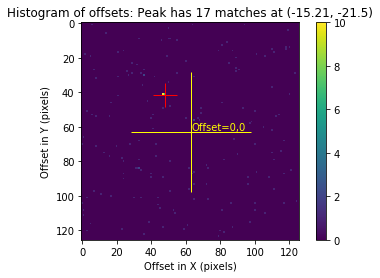

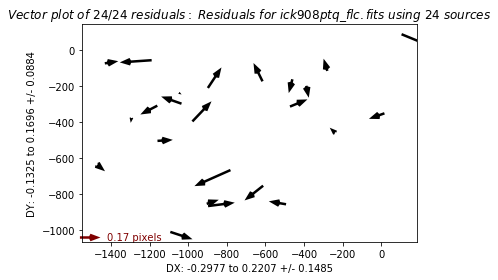

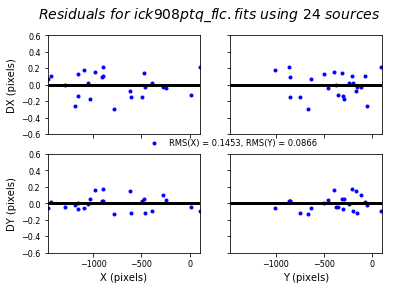

In [33]:
tweakreg.TweakReg('*_flc.fits',
                  enforce_user_order=False,
                  imagefindcfg={'threshold': 200, 'conv_width': 3.5, 'dqbits': ~4096},
                  refimage='f160w_drz_sci.fits', 
                  refimagefindcfg={'threshold': 50, 'conv_width': 2.5},
                  shiftfile=True,
                  outshifts='shift657_flc.txt',
                  searchrad=5.0,
                  ylimit=0.6,
                  updatehdr=True,
                  wcsname='UVIS_FLC',
                  reusename=True,
                  interactive=False)

## 6a. Inspect the shift file to verify the pointing residuals 

With a `threshold` of 200 sigma, TweakReg generates catalogs with several hundred objects per UVIS image and it matches 20-70 objects to the IR reference catalog. The computed offsets written to the shift file are reported at the scale of the reference image (0.08”/pixel for the drizzled IR mosaic). Thus a fit rms ~0.20 pixels (below) at the IR scale is equivalent to an rms ~0.10 pixels at the native UVIS scale (0.04"/pixel).

Because each visit was acquired using a unique pair of Guide Stars, the three FLC exposures making up each visit should have roughly similar residual corrections to the WCS, which can be seen in the table below. Note that residual offsets for visit 05 are much larger than those found for the other three visits at nearly 3".

In [34]:
shift_table=Table.read('shift657_flc.txt', format='ascii.no_header',
                       names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

<Table length=12>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
ick905k5q_flc.fits   -1.00   -0.56 359.993 1.00004    0.17    0.11
ick905keq_flc.fits   -0.97   -0.56 359.993 1.00003    0.17    0.10
ick905knq_flc.fits   -0.94   -0.60 359.992 1.00004    0.16    0.10
ick906kwq_flc.fits  -12.01  -20.55 359.990 1.00005    0.17    0.21
ick906l5q_flc.fits  -11.96  -20.55 359.990 1.00006    0.17    0.20
ick906leq_flc.fits  -12.02  -20.64 359.991 1.00007    0.14    0.14
ick907nkq_flc.fits  -11.78  -27.93 359.992 1.00009    0.14    0.13
ick907o1q_flc.fits  -11.82  -27.97 359.991 1.00009    0.13    0.13
ick907ouq_flc.fits  -11.76  -28.06 359.991 1.00004    0.13    0.12
ick908pbq_flc.fits  -14.65  -21.08 359.992 1.00008    0.14    0.11
ick908pkq_flc.fits  -14.64  -21.01 359.989 1.00008    0.15    0.10
ick908ptq_flc.fits  -14.60  -21.05 359.990 1.00009    0.15    0.09

## 6b. Inspect the UVIS fits

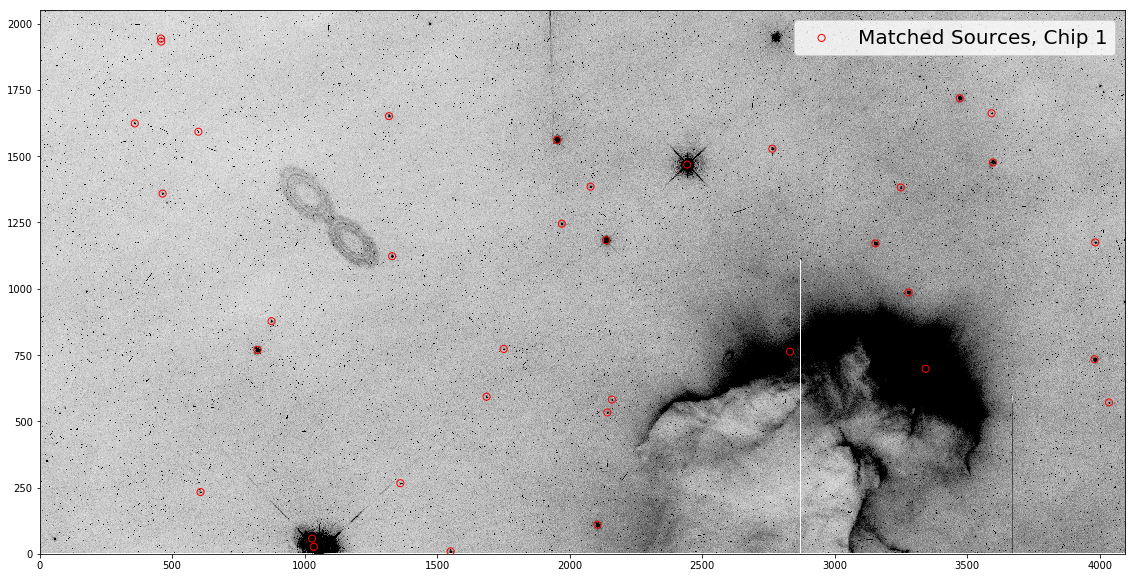

In [35]:
#v06a matched sources (chip 1)
plt.figure(figsize=(20, 10))
chip1_data = fits.open('ick906l5q_flc.fits')['SCI', 2].data
z1, z2 = zscale.get_limits(chip1_data)
plt.imshow(chip1_data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick906l5q_flc_catalog_fit.match')  # load match file in astropy table
match_tab_chip1 = match_tab[match_tab['col15'] == 2]  # filter table for sources on chip 1 (on ext 4)
x_cord, y_cord = match_tab_chip1['col11'], match_tab_chip1['col12']
plt.scatter(x_cord, y_cord, s=50, edgecolor='r', facecolor='None', label='Matched Sources, Chip 1')
plt.ylim(0, 2051)
plt.xlim(0, 4096)
plt.legend(loc='best', fontsize=20)

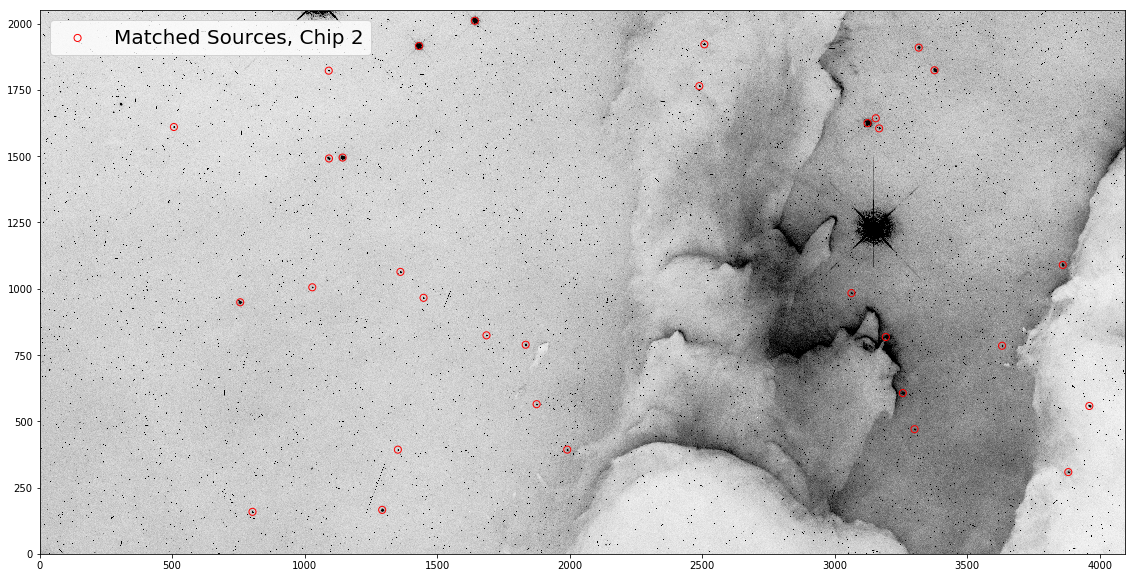

In [36]:
#v06a matched sources (chip 2)
plt.figure(figsize=(20, 10))
chip1_data = fits.open('ick906l5q_flc.fits')['SCI', 1].data
z1, z2 = zscale.get_limits(chip1_data)
plt.imshow(chip1_data, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
match_tab = ascii.read('ick906l5q_flc_catalog_fit.match')  # load match file in astropy table
match_tab_chip2 = match_tab[match_tab['col15'] == 1]  # filter table for sources on chip 2 (on ext 1)
x_cord, y_cord = match_tab_chip2['col11'], match_tab_chip2['col12']
plt.scatter(x_cord, y_cord, s=50, edgecolor='r', facecolor='None', label='Matched Sources, Chip 2')
plt.ylim(0, 2051)
plt.xlim(0, 4096)
plt.legend(loc='best', fontsize=20)

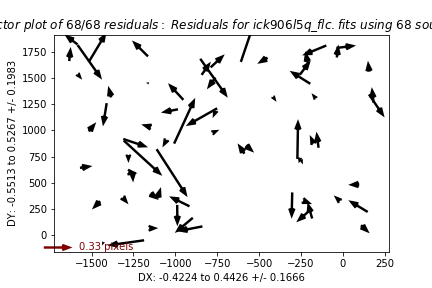

In [37]:
# v06a vector residuals
Image(filename='vector_ick906l5q_flc.png', width=600, height=300)

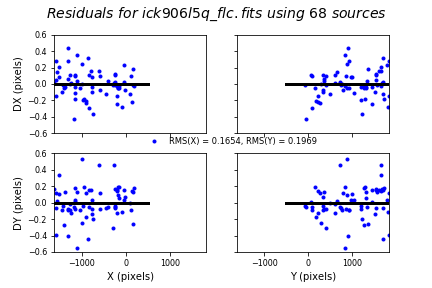

In [38]:
# v06a fit residuals
Image(filename='residuals_ick906l5q_flc.png', width=600, height=300)

# 7. Drizzling the F657N mosaic

The full set of 12 FLC frames have now been aligned and may be drizzled to a mosaic exactly half the scale (0.04"/pixel) of the original IR mosaic (0.08"/pixel). The same output WCS paramters: `final_rot`,`final_ra`, and `final_dec` values are used, but the `final_outnx` and `final_outny` are now twice the size of the IR mosaic at 8000x9000 pixels. 

To save time for this notebook, the visit-level cosmic ray flags are assumed to be adequate, Steps 3, 4, 5, 6 are turned off, and the parameter `resetbits` is set to '0' to avoid wiping out the 4096 flags in the FLC data quality arrays. Also, the sky background levels have been provided via the skyfile parameter, but users would typically set `skymethod='match'` to compute the sky background levels. 

To further improve cosmic-ray rejection in the chip gap, AstroDrizzle may alternatively be run with all steps turned on as shown in the text below and with `resetbits=4096` to update the DQ flags. 

```
astrodrizzle.AstroDrizzle('*flc.fits',
                          output='f657n_improved',
                          preserve=False,
                          clean=False,
                          build=False,
                          context=False,
                          resetbits=4096,
                          skymethod='match',
                          combine_type='minmed',
                          final_bits='64,16',
                          final_wcs=True,
                          final_scale=0.04,
                          final_rot=-35,
                          final_ra=274.721587,
                          final_dec=-13.841549,
                          final_outnx=8000,
                          final_outny=9000)
```

In [39]:
astrodrizzle.AstroDrizzle('*flc.fits',
                          output='f657n',
                          preserve=False,
                          clean=False,
                          build=False,
                          context=False,
                          resetbits=0,
                          skyfile='skyfile.txt',
                          driz_separate=False,
                          median=False,
                          blot=False,
                          driz_cr=False,
                          final_bits='64,16',
                          final_wcs=True,
                          final_scale=0.04,
                          final_rot=-35,
                          final_ra=274.721587,
                          final_dec=-13.841549,
                          final_outnx=8000,
                          final_outny=9000)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 20:11:04.470 (20/03/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 20:11:04.470 (20/03/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 7.3.0]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:11:04.475 (20/03/2019)


==== Processing Step  Initialization  started at  20:11:04.475 (20/03/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f657n_drc.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:No context image will be created for ick905k5q_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick905keq_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick905knq_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick906kwq_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick906l5q_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick906leq_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick907nkq_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick907o1q_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick907ouq_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick908pbq_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick908pkq_flc.fits


INFO:drizzlepac.imageObject:No context image will be created for ick908ptq_flc.fits


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:drizzlepac.imageObject:No context image will be created for f657n_drc.fits


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 274.721587  -13.841549  


CRVAL : 274.721587  -13.841549  


INFO:astropy.wcs.wcs:CRPIX : 4000.5  4500.5  


CRPIX : 4000.5  4500.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -9.101689380988799e-06  -6.373071515011623e-06  


CD1_1 CD1_2  : -9.101689380988799e-06  -6.373071515011623e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -6.373071515011623e-06  9.101689380988799e-06  


CD2_1 CD2_2  : -6.373071515011623e-06  9.101689380988799e-06  


INFO:astropy.wcs.wcs:NAXIS : 8000  9000


NAXIS : 8000  9000


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 888 Mb.


*  Estimated memory usage:  up to 888 Mb.


INFO:drizzlepac.processInput:*  Output image size:       8000 X 9000 pixels. 


*  Output image size:       8000 X 9000 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 823 Mb. 


*  Output image file:       ~ 823 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:11:07.81 (20/03/2019)


==== Processing Step  Initialization  finished at  20:11:07.81 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	False


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flc.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f657n


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	0


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:11:07.818 (20/03/2019)


==== Processing Step  Static Mask  started at  20:11:07.818 (20/03/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 108.962808;   rms = 47.844173;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 71.356111;   rms = 33.889484;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 109.195287;   rms = 51.917614;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 71.596486;   rms = 36.581364;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 129.843597;   rms = 54.751423;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 76.073627;   rms = 41.518929;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 137.416181;   rms = 51.315552;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 119.131440;   rms = 41.695034;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 137.962960;   rms = 52.676998;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 118.985219;   rms = 45.493393;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 136.325370;   rms = 52.691093;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 108.990976;   rms = 49.355392;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 161.899517;   rms = 27.907026;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 155.808909;   rms = 54.251663;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 160.647280;   rms = 27.722502;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 157.549520;   rms = 50.212975;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 162.185688;   rms = 28.314404;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 160.476455;   rms = 47.406418;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 173.637024;   rms = 26.087910;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 142.246113;   rms = 54.999462;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 165.213391;   rms = 25.563440;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 144.744259;   rms = 48.547604;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode = 163.359538;   rms = 25.816931;   static_sig = 4.00


INFO:drizzlepac.staticMask:  mode = 149.455210;   rms = 42.451820;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3UVIS_2051x4096_1_staticMask.fits


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3UVIS_2051x4096_2_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  20:11:15.031 (20/03/2019)


==== Processing Step  Static Mask  finished at  20:11:15.031 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:11:15.033 (20/03/2019)


==== Processing Step  Subtract Sky  started at  20:11:15.033 (20/03/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	skyfile.txt


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	localmin


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick905k5q_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 5.164297443401196


Setting  MDRIZSKY = 5.164297443401196


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick905k5q_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 5.164297443401196


Setting  MDRIZSKY = 5.164297443401196


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick905keq_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 4.74633287566588


Setting  MDRIZSKY = 4.74633287566588


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick905keq_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 4.74633287566588


Setting  MDRIZSKY = 4.74633287566588


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick905knq_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 4.821130750651644


Setting  MDRIZSKY = 4.821130750651644


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick905knq_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 4.821130750651644


Setting  MDRIZSKY = 4.821130750651644


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick906kwq_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 0.0


Setting  MDRIZSKY = 0.0


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick906kwq_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 0.0


Setting  MDRIZSKY = 0.0


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick906l5q_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 0.197409803566439


Setting  MDRIZSKY = 0.197409803566439


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick906l5q_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 0.197409803566439


Setting  MDRIZSKY = 0.197409803566439


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick906leq_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 0.12091305584043


Setting  MDRIZSKY = 0.12091305584043


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick906leq_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 0.12091305584043


Setting  MDRIZSKY = 0.12091305584043


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick907nkq_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 5.216696190655276


Setting  MDRIZSKY = 5.216696190655276


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick907nkq_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 5.216696190655276


Setting  MDRIZSKY = 5.216696190655276


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick907o1q_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 5.199967907014416


Setting  MDRIZSKY = 5.199967907014416


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick907o1q_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 5.199967907014416


Setting  MDRIZSKY = 5.199967907014416


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick907ouq_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 5.015783474073655


Setting  MDRIZSKY = 5.015783474073655


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick907ouq_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 5.015783474073655


Setting  MDRIZSKY = 5.015783474073655


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick908pbq_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 3.326444411950823


Setting  MDRIZSKY = 3.326444411950823


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick908pbq_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 3.326444411950823


Setting  MDRIZSKY = 3.326444411950823


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick908pkq_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 2.939654580840035


Setting  MDRIZSKY = 2.939654580840035


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick908pkq_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 2.939654580840035


Setting  MDRIZSKY = 2.939654580840035


INFO:drizzlepac.sky:    ...updating MDRIZSKY with user-supplied value.


    ...updating MDRIZSKY with user-supplied value.


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick908ptq_flc.fits[SCI,1]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 2.784643205076933


Setting  MDRIZSKY = 2.784643205076933


INFO:drizzlepac.sky:Updating keyword MDRIZSKY in ick908ptq_flc.fits[SCI,2]


INFO:drizzlepac.sky:Setting  MDRIZSKY = 2.784643205076933


Setting  MDRIZSKY = 2.784643205076933


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:11:16.340 (20/03/2019)


==== Processing Step  Subtract Sky  finished at  20:11:16.340 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:11:16.341 (20/03/2019)


==== Processing Step  Separate Drizzle  started at  20:11:16.341 (20/03/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:11:16.342 (20/03/2019)


==== Processing Step  Separate Drizzle  finished at  20:11:16.342 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:11:16.344 (20/03/2019)


==== Processing Step  Create Median  started at  20:11:16.344 (20/03/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:11:16.345 (20/03/2019)


==== Processing Step  Blot  started at  20:11:16.345 (20/03/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:11:16.346 (20/03/2019)


==== Processing Step  Blot  finished at  20:11:16.346 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:11:16.34 (20/03/2019)


==== Processing Step  Driz_CR  started at  20:11:16.34 (20/03/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:11:16.349 (20/03/2019)


==== Processing Step  Final Drizzle  started at  20:11:16.349 (20/03/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 80, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	80


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 274.721587  -13.841549  


CRVAL : 274.721587  -13.841549  


INFO:astropy.wcs.wcs:CRPIX : 4000.5  4500.5  


CRPIX : 4000.5  4500.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -9.101689380988799e-06  -6.373071515011623e-06  


CD1_1 CD1_2  : -9.101689380988799e-06  -6.373071515011623e-06  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -6.373071515011623e-06  9.101689380988799e-06  


CD2_1 CD2_2  : -6.373071515011623e-06  9.101689380988799e-06  


INFO:astropy.wcs.wcs:NAXIS : 8000  9000


NAXIS : 8000  9000


INFO:drizzlepac.adrizzle:-Drizzle input: ick905k5q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 5.164297 to ick905k5q_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick905k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick905k5q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 5.164297 to ick905k5q_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick905k5q_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick905keq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 4.746333 to ick905keq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick905keq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick905keq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 4.746333 to ick905keq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick905keq_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick905knq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 4.821131 to ick905knq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick905knq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick905knq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 4.821131 to ick905knq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick905knq_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick906kwq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ick906kwq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick906kwq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick906kwq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ick906kwq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick906kwq_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick906l5q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.197410 to ick906l5q_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick906l5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick906l5q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 0.197410 to ick906l5q_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick906l5q_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick906leq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.120913 to ick906leq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick906leq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick906leq_flc.fits[sci,2]

INFO:drizzlepac.adrizzle:Applying sky value of 0.120913 to ick906leq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick906leq_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick907nkq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 5.216696 to ick907nkq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick907nkq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick907nkq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 5.216696 to ick907nkq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick907nkq_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick907o1q_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 5.199968 to ick907o1q_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick907o1q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick907o1q_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 5.199968 to ick907o1q_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick907o1q_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick907ouq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 5.015783 to ick907ouq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick907ouq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick907ouq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 5.015783 to ick907ouq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick907ouq_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick908pbq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 3.326444 to ick908pbq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick908pbq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick908pbq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 3.326444 to ick908pbq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick908pbq_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick908pkq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 2.939655 to ick908pkq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick908pkq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick908pkq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 2.939655 to ick908pkq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick908pkq_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick908ptq_flc.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 2.784643 to ick908ptq_flc.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ick908ptq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ick908ptq_flc.fits[sci,2]


INFO:drizzlepac.adrizzle:Applying sky value of 2.784643 to ick908ptq_flc.fits[sci,2]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 2


INFO:drizzlepac.adrizzle:Writing out mask file: ick908ptq_sci2_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f657n_drc_sci.fits


-Generating simple FITS output: f657n_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f657n_drc_sci.fits


Writing out image to disk: f657n_drc_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f657n_drc_wht.fits


Writing out image to disk: f657n_drc_wht.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:12:32.547 (20/03/2019)


==== Processing Step  Final Drizzle  finished at  20:12:32.547 (20/03/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 20:12:32.550 (20/03/2019).


AstroDrizzle Version 2.2.6 is finished processing at 20:12:32.550 (20/03/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.3348 sec.


         Initialization          3.3348 sec.


INFO:drizzlepac.util:            Static Mask          7.2130 sec.


            Static Mask          7.2130 sec.


INFO:drizzlepac.util:           Subtract Sky          1.3064 sec.


           Subtract Sky          1.3064 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0010 sec.


       Separate Drizzle          0.0010 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0010 sec.


                   Blot          0.0010 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          76.1979 sec.


          Final Drizzle          76.1979 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          88.0539 sec.


                  Total          88.0539 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


## 7a. Display the combined DRC science and weight images 

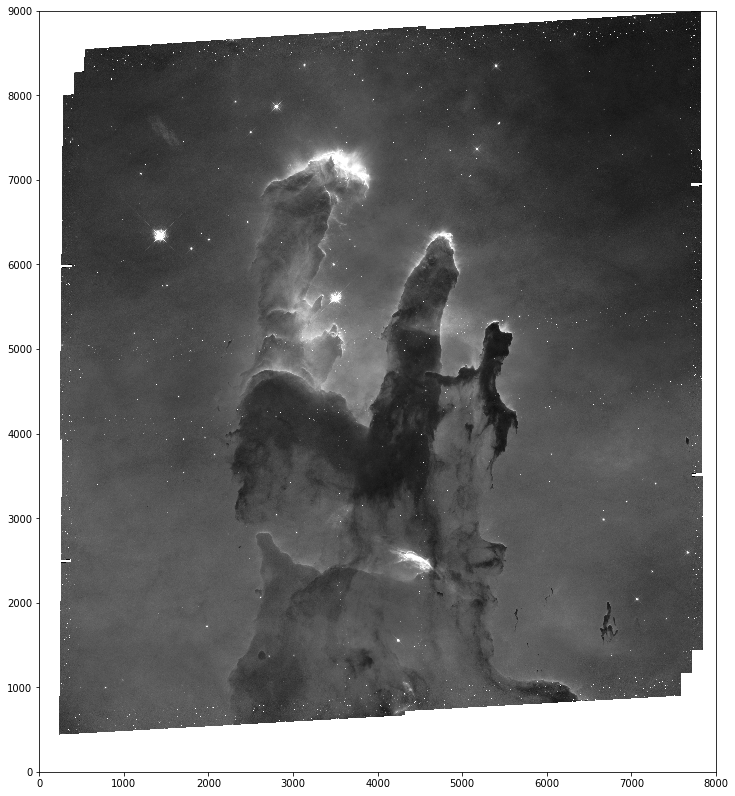

In [40]:
sci = fits.getdata('f657n_drc_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=0, vmax=1, cmap='Greys_r', origin='lower')

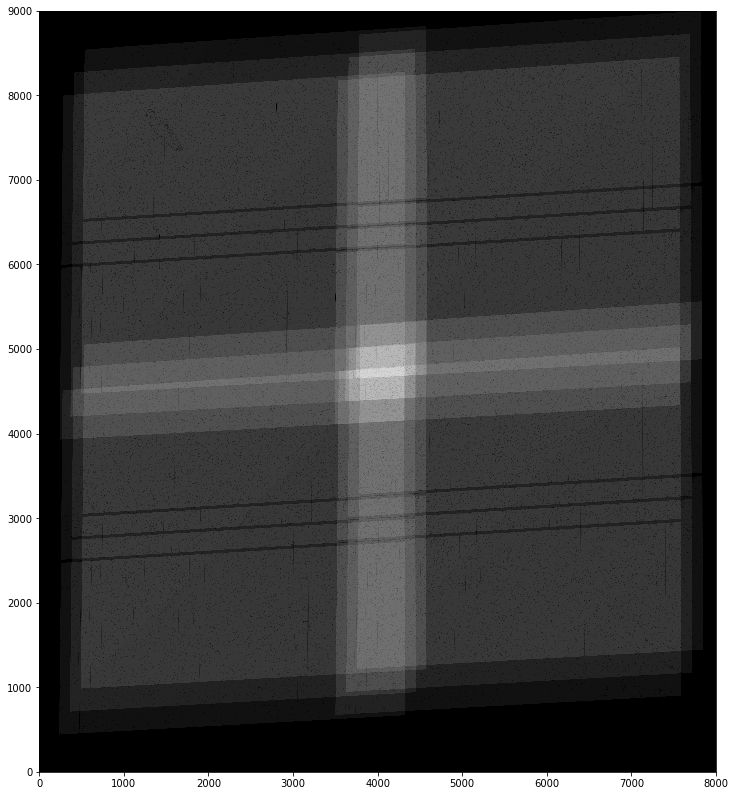

In [41]:
sci = fits.getdata('f657n_drc_wht.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=0, vmax=10000, cmap='Greys_r', origin='lower')

# Summary

This notebook provides the methodology for creating UVIS and IR mosaics of M16, as well as recommendations for key parameters. As such, it is relevant for users combining multi-visit observations from any HST imaging program, whether mosaics or single pointings. In this example, the IR F160W mosaic was chosen to define the reference frame, since it contained the largest number of point sources, despite the pixels being undersampled. Typically, the detector with the best resolution and PSF sampling would be selected as the reference, but in this case the UVIS catalogs were too sparse.

When building up an expanded reference catalog on the sky, TweakReg was allowed to select the order in which tiles were aligned, since it made little impact on the results. For aligning mosaics with more tiles, however, users are recommended to experiment with changing the order in which images are aligned and seeing how this changes the astrometric residuals.  Generally, users are advised to start from the center of the mosaic and work their way out to avoid propogation of errors across the mosaic. 

Alternatively, mosaic tiles can be aligned directly to an absolute reference catalog such as GAIA, when a sufficient number of stars are available in the input frames for alignment. For more detail on this methodology, see the notebook 'aligning_to_catalogs.ipynb'. 

# About this Notebook

    Author: J. Mack, STScI WFC3 Team  
    Updated: December 17, 2018